В DATA_DIR и EXCEL_DIR нужно добавить адреса папок с las файлами и excel соответственно. (те, которые были даны в качестве обучения для хакатона) В EXCEL - название excel таблицы

Аналогично в NEW_DATA_DIR, NEW_EXCEL_DIR и NEW_EXCEL нужно добавить адреса новых папок с las файлами и excel: то, на чём будет проводиться тестирование

In [1]:
import lasio
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
from prov import identifier

import view_well_file
import interpolation

mpl.rcParams.update({'font.size':20})

import importlib
importlib.reload(view_well_file)

DATA_DIR = "C:\\Users\\1\\Downloads\\data\\las"
EXCEL_DIR = "C:\\Users\\1\\Downloads\\data"
EXCEL = "\\Отбивки пласта АС11-2.xlsx"

NEW_DATA_DIR = "C:\\Users\\1\\Downloads\\new data\\las"
NEW_EXCEL_DIR = "C:\\Users\\1\\Downloads\\new data"
NEW_EXCEL = "\\Отбивки пласта АС11-2.xlsx"

# 1 часть: кластеризация скважин

In [2]:
well_idx = []
for filename in os.listdir(DATA_DIR):
    well_idx.append(filename.split("_")[0])
well_idx = set(well_idx)



excel = pd.read_excel(EXCEL_DIR + EXCEL)

upper_bounds = excel.iloc[::2].copy()
upper_bounds.rename(columns={'Z': 'upper'}, inplace=True)
upper_bounds.drop(['Surface', 'MD'], inplace=True, axis=1)

lower_bounds = excel.iloc[1::2].copy()
lower_bounds.rename(columns={'Z': 'lower'}, inplace=True)
lower_bounds.drop(['Surface', 'MD'], inplace=True, axis=1)



target_layers = pd.merge(upper_bounds, lower_bounds, on='Well identifier', how='outer')
target_layers['Well identifier'] = target_layers['Well identifier'].astype(str)
target_layers = target_layers[target_layers['Well identifier'].isin(well_idx)]

#target_layers

#target_layers.iloc[30]
#вывод данных для одной из скважин 

Визуализация данных для скважины номер N

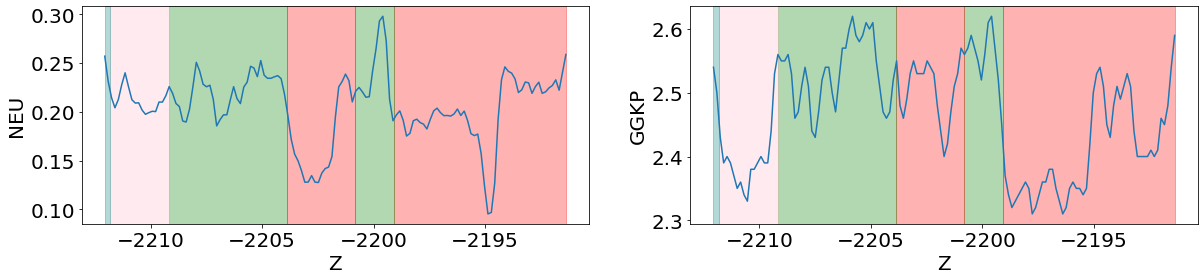

In [3]:
N=20
z, ggkp, neu = view_well_file.view_well(N, target_layers)

Интерполяция GGKP той же скважины

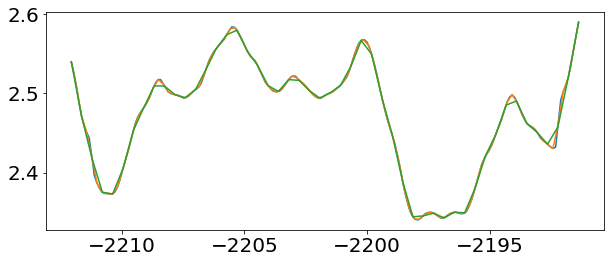

In [4]:
width = 6
z_interp, ggkp_interp = interpolation.interpolate_lin_av(z, ggkp, 200, width)
z_interp1, ggkp_interp1 = interpolation.interpolate_lin_av(z, ggkp, 100, width)
z_interp2, ggkp_interp2 = interpolation.interpolate_lin_av(z, ggkp, 50, width)

plt.figure(figsize=(10, 4))
plt.plot(z_interp, ggkp_interp)
plt.plot(z_interp1, ggkp_interp1)
plt.plot(z_interp2, ggkp_interp2)
plt.show()

Интерполируем данные

In [5]:
data = []

interpol_func = interpolation.interpolate_lin_av
new_size = 100

for well_index in range(len(well_idx)):
    well_name = target_layers.iloc[well_index]['Well identifier']
    las = lasio.read(os.path.join(DATA_DIR, f"{target_layers.iloc[well_index]['Well identifier']}_continuous.las"))
    target_layer_idx = np.where((las['Z'] < target_layers.iloc[well_index].upper) & (las['Z'] > target_layers.iloc[well_index].lower))
    data_interp = interpol_func(las["Z"][target_layer_idx], las["GGKP"][target_layer_idx], new_size, width)
    data.append(np.stack(data_interp))

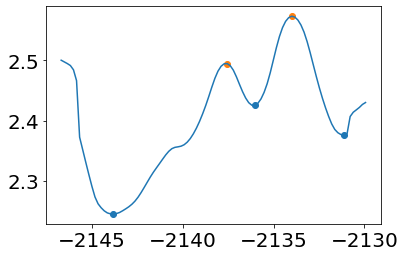

In [6]:
test_data = np.array(data)[9, ...].copy()
test_data[1] = interpolation.average(test_data[1], 6)
peak_width = 4

min_idx, max_idx = [], []

for i in range(peak_width, test_data.shape[1] - peak_width):
    if (test_data[1][i] >= test_data[1][i-peak_width:i]).all() and (test_data[1][i] >= test_data[1][i:i+peak_width]).all():
        max_idx.append(i)
    if (test_data[1][i] <= test_data[1][i-peak_width:i]).all() and (test_data[1][i] <= test_data[1][i:i+peak_width]).all():
        min_idx.append(i)

plt.plot(test_data[0], test_data[1])
plt.scatter(test_data[0][min_idx], test_data[1][min_idx])
plt.scatter(test_data[0][max_idx], test_data[1][max_idx])

In [7]:
import matplotlib.cm as cm

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score

In [8]:
data = np.array(data)
print(data.shape)
new_data = np.empty((len(well_idx),101))
for i in range(len(well_idx)):
    new_data[i] = np.concatenate([[data[i, 0].mean()], data[i, 1]])
    new_data[i] -= new_data[i].mean()
    new_data[i] /= new_data[i].max()-new_data[i].min()
new_data.shape, data.shape

(41, 2, 100)


((41, 101), (41, 2, 100))

Пробуем разбить данные на разное число кластеров от 2 до 19 и считаем silhoette score для каждого случая

For n_clusters = 2 The average silhouette_score is : 0.14010261884536232
For n_clusters = 3 The average silhouette_score is : 0.1327995545937377
For n_clusters = 4 The average silhouette_score is : 0.1450460065919046
For n_clusters = 5 The average silhouette_score is : 0.1683014916584213
For n_clusters = 6 The average silhouette_score is : 0.14961155448845143
For n_clusters = 7 The average silhouette_score is : 0.17265455472814228
For n_clusters = 8 The average silhouette_score is : 0.1753468597301907
For n_clusters = 9 The average silhouette_score is : 0.15475183175243792
For n_clusters = 10 The average silhouette_score is : 0.15108061963266892
For n_clusters = 11 The average silhouette_score is : 0.13942810769564387
For n_clusters = 12 The average silhouette_score is : 0.14822706492922816
For n_clusters = 13 The average silhouette_score is : 0.1353338440736946
For n_clusters = 14 The average silhouette_score is : 0.11903440096681038
For n_clusters = 15 The average silhouette_score is

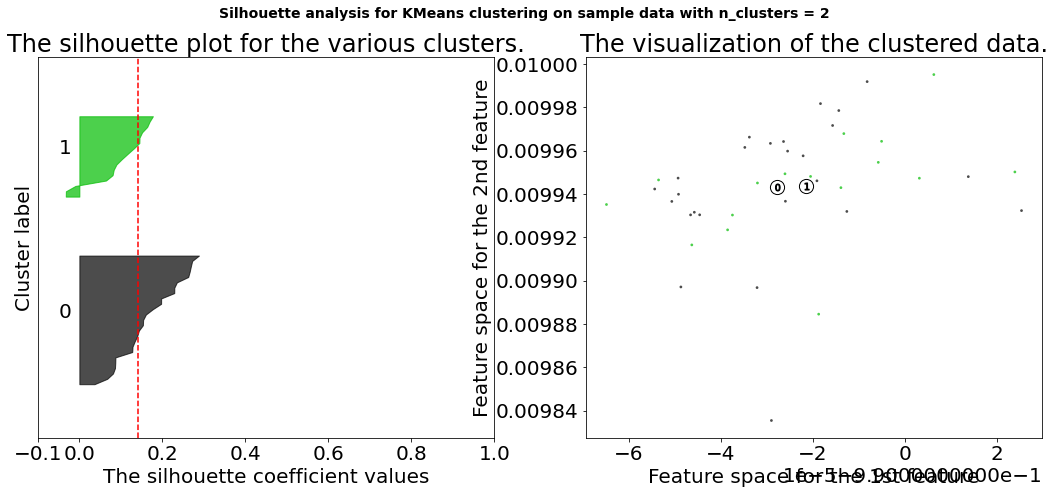

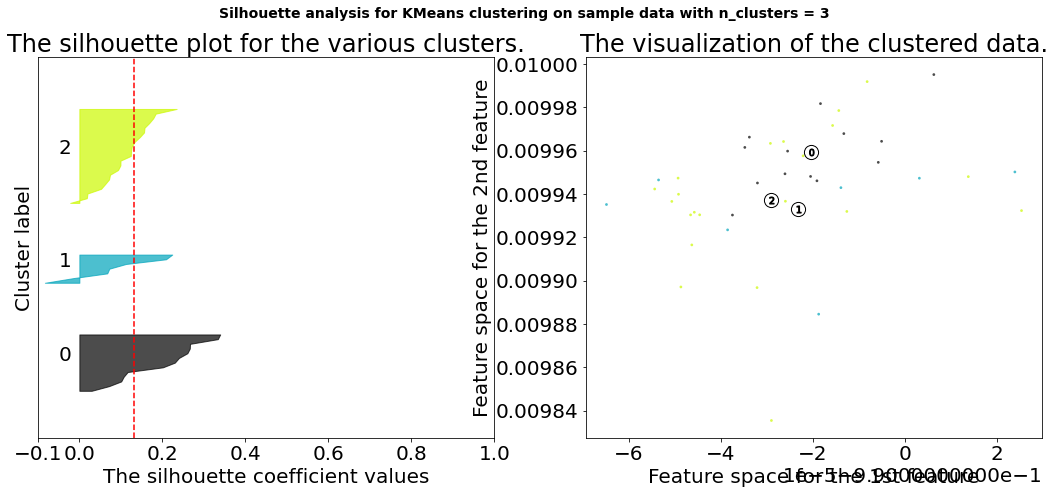

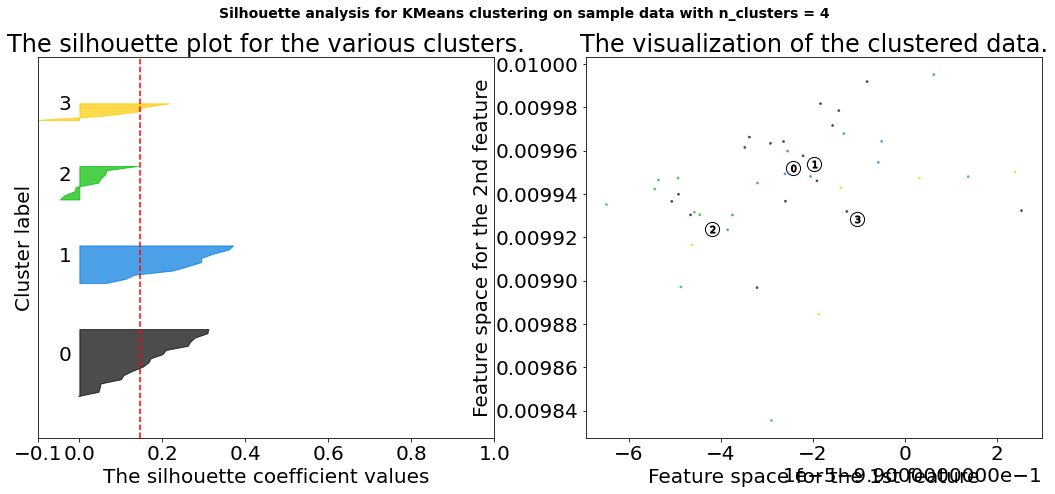

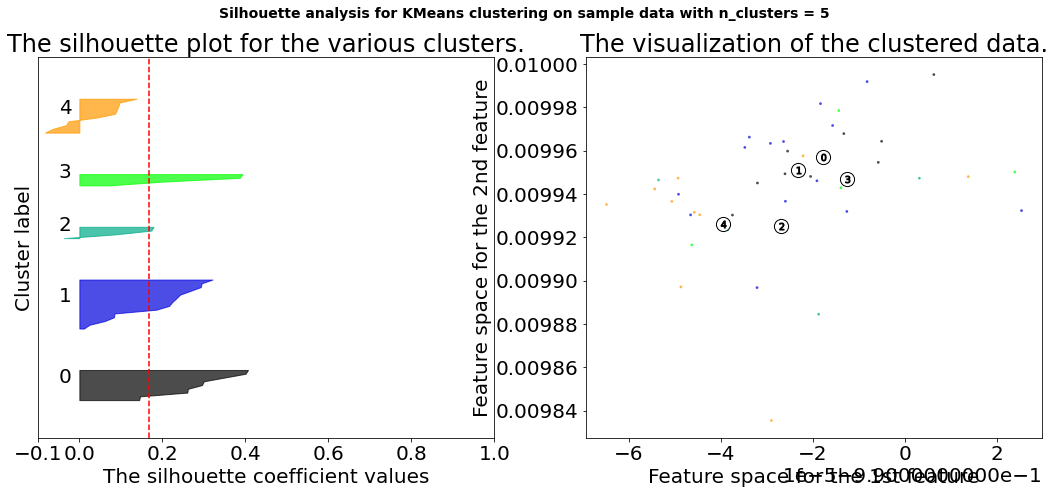

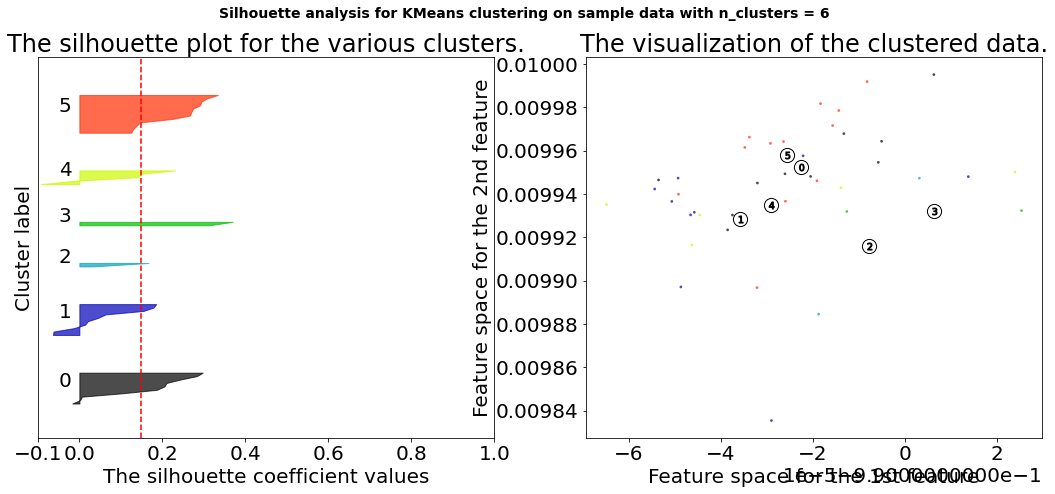

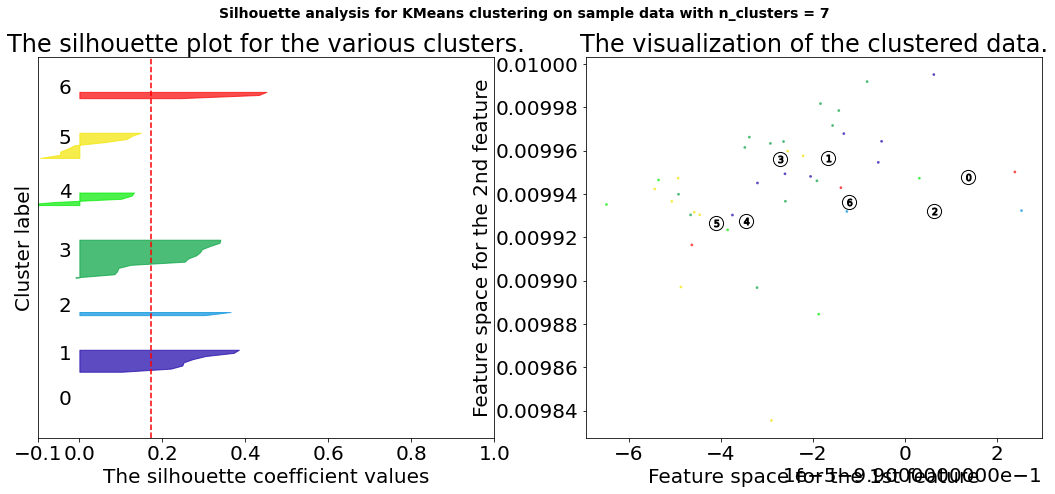

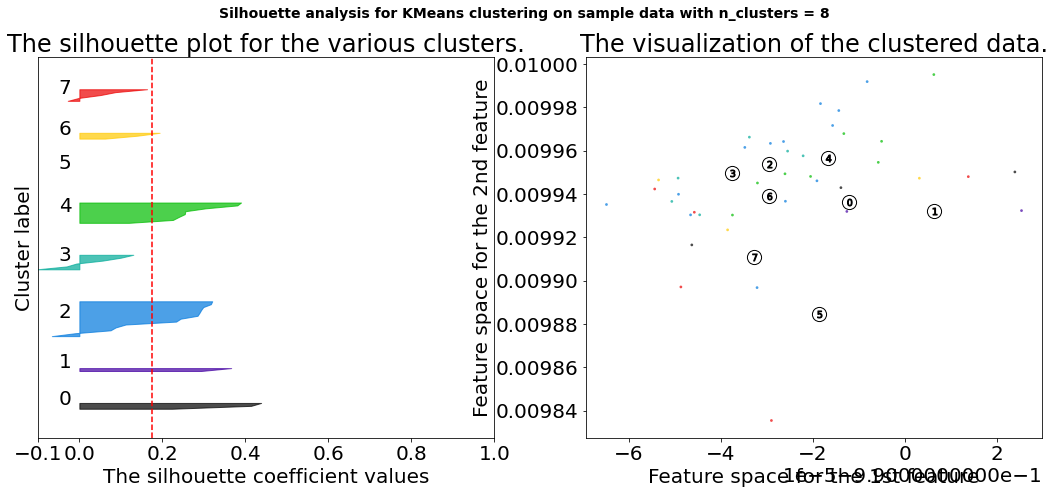

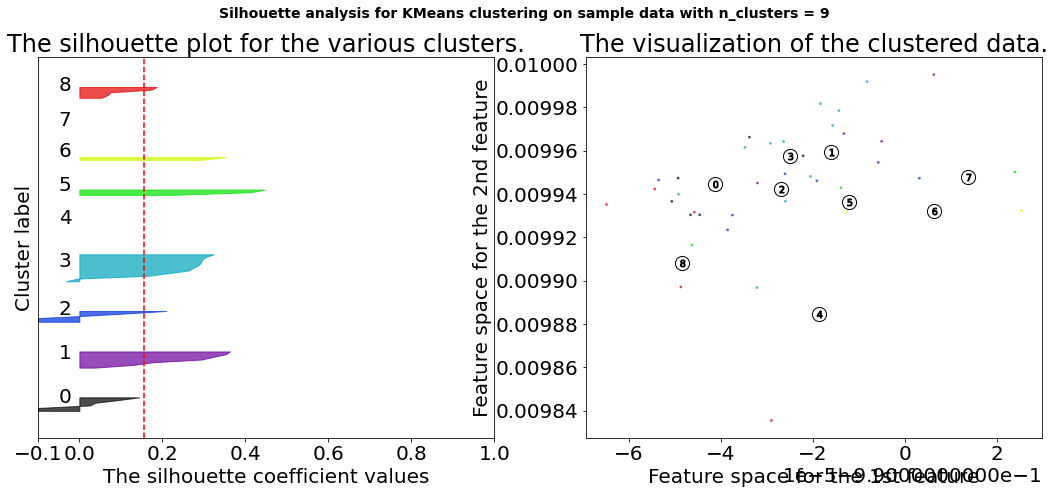

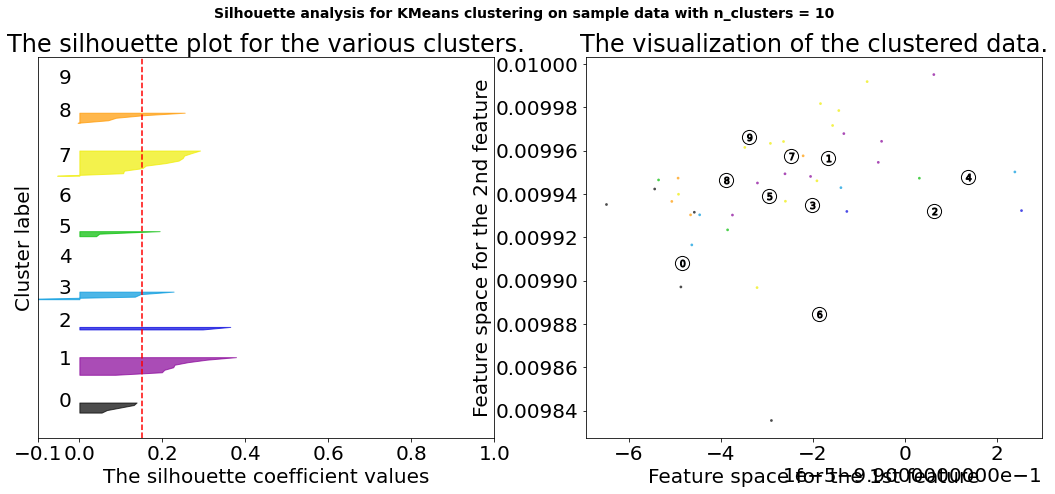

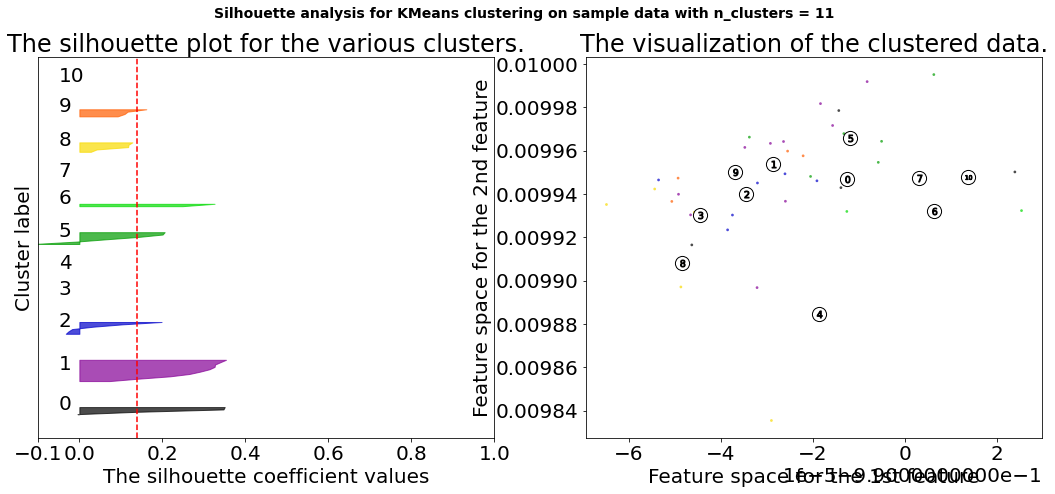

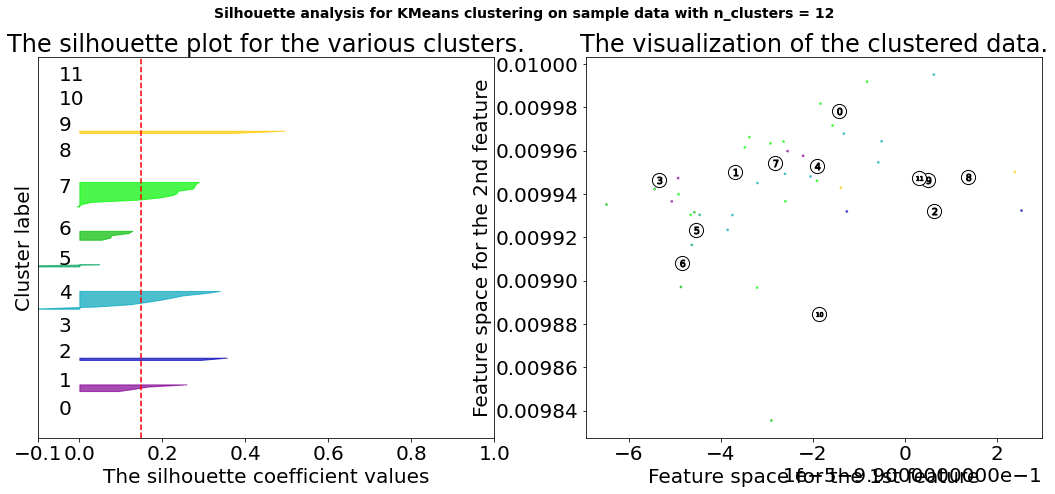

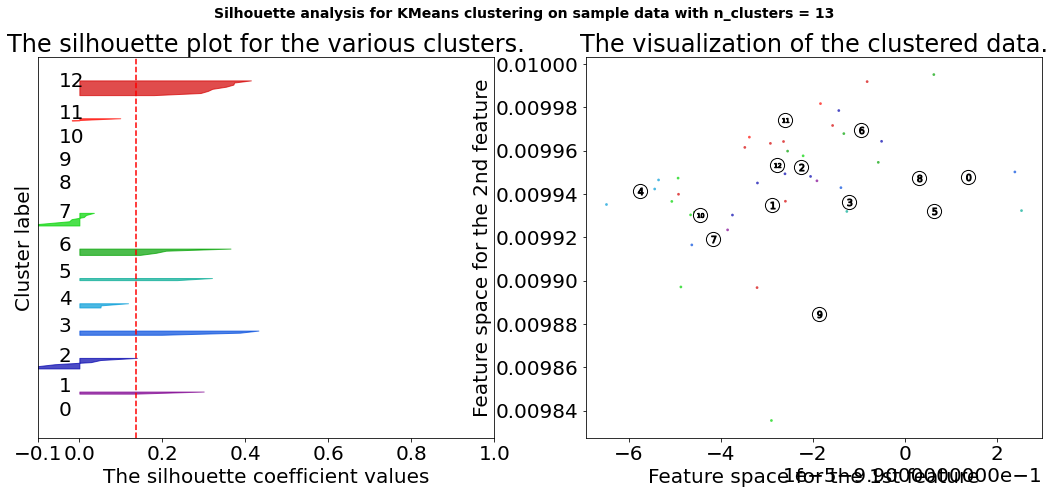

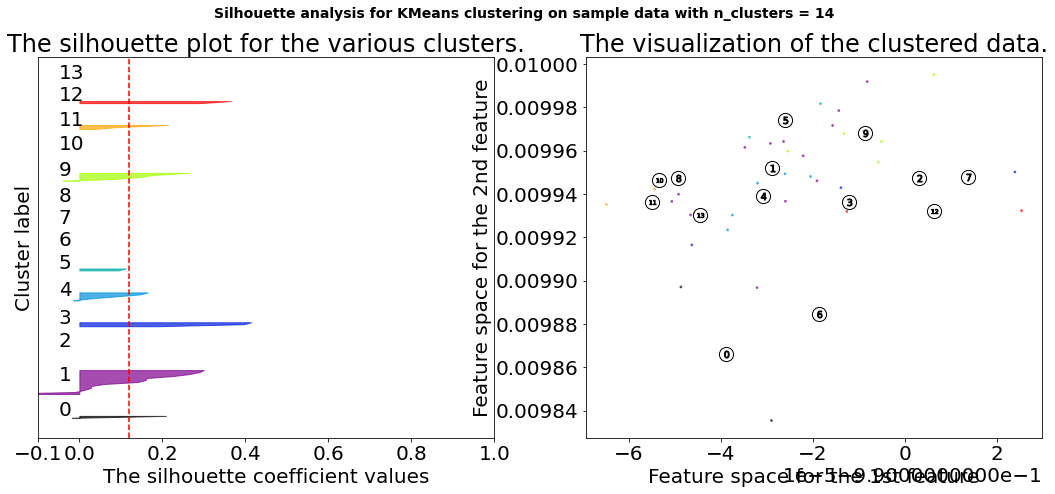

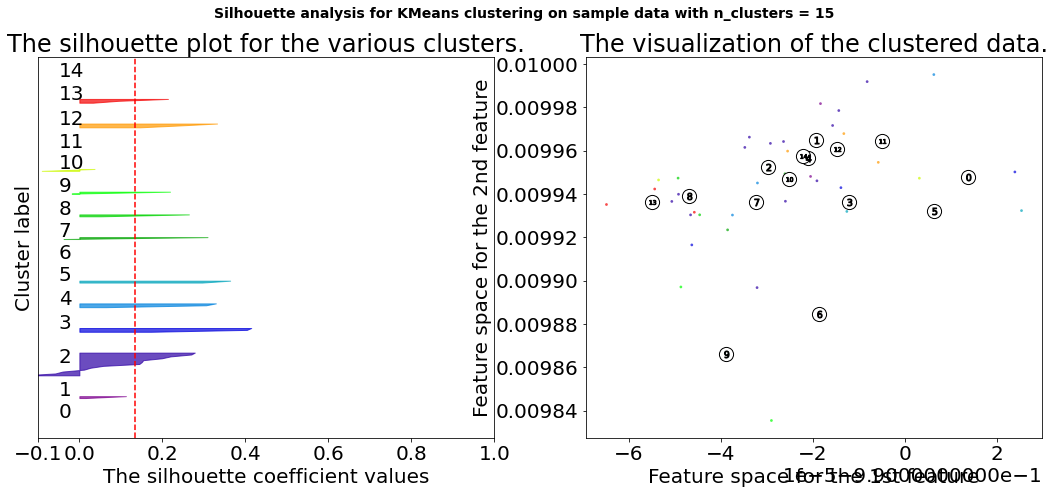

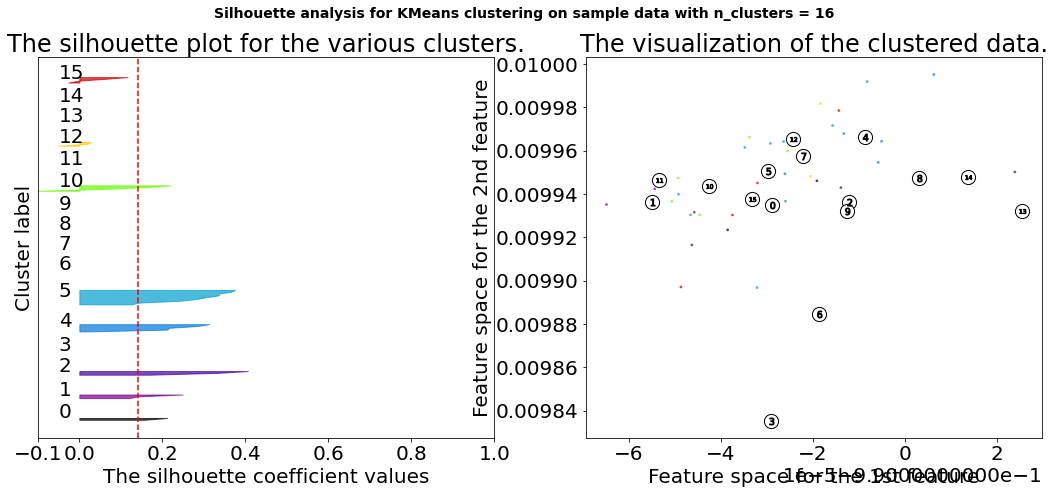

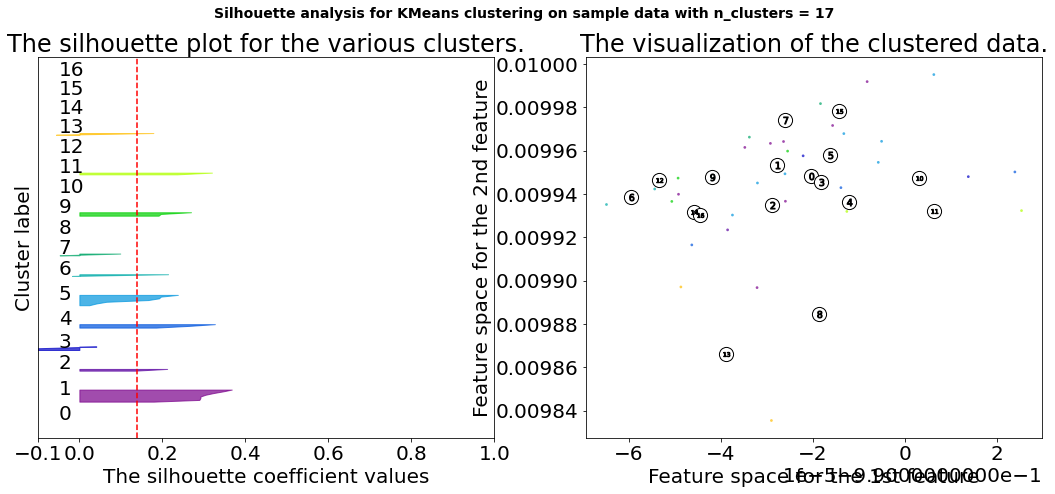

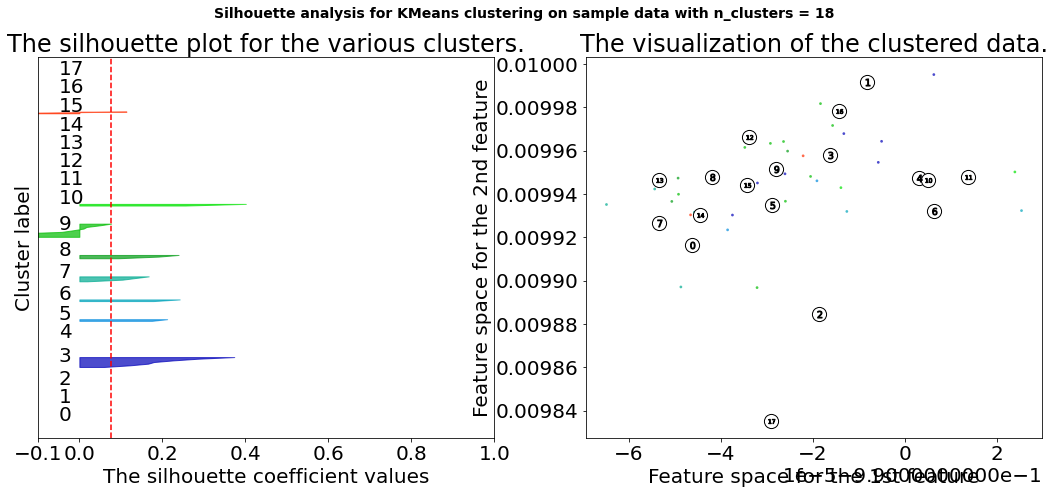

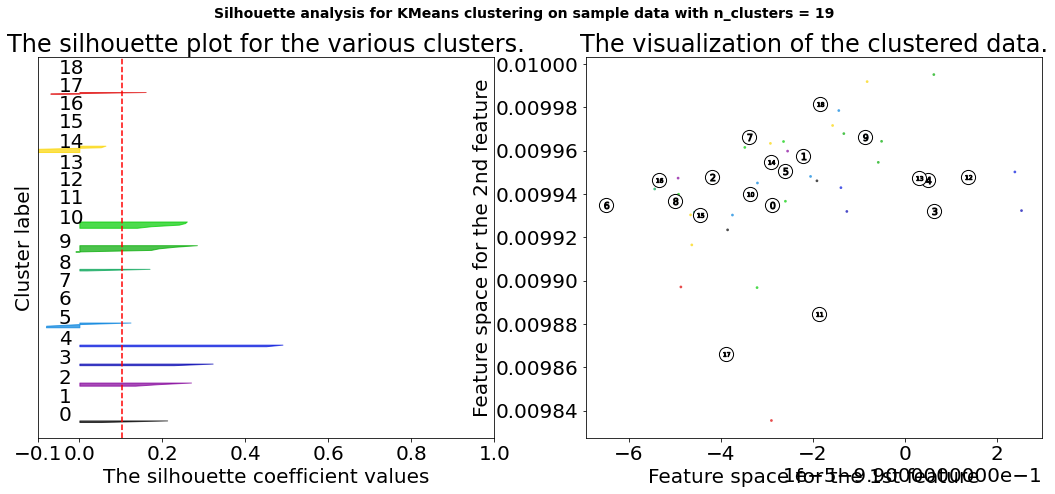

In [9]:
X = new_data#[:, 1, :]

silhouette = []

range_n_clusters = list(range(2,20))

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )
    silhouette.append(silhouette_avg)
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    
    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

Разбиваем на то число кластеров, у которого silhouette наибольший

In [10]:
n_clusters = silhouette.index(max(silhouette)) + 2
#for n_clusters in range(2, 10):
cluster_alg = KMeans(n_clusters)
cluster_alg.fit(new_data)
#print(cluster_alg.labels_)
print('Number of clusters is', n_clusters, 'and silhouette score is', silhouette_score(new_data, cluster_alg.labels_))

Number of clusters is 8 and silhouette score is 0.1610156660878561


Графики GGKP с номером кластеров, которым они принадлежат

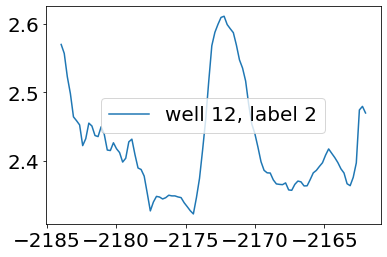

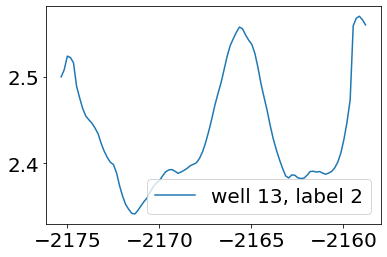

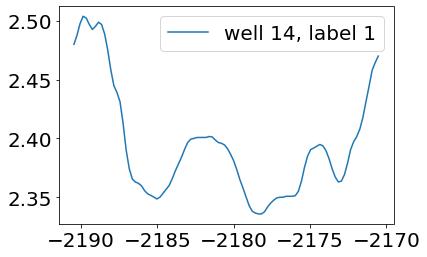

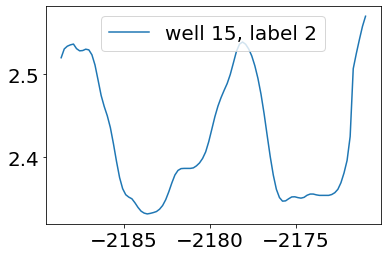

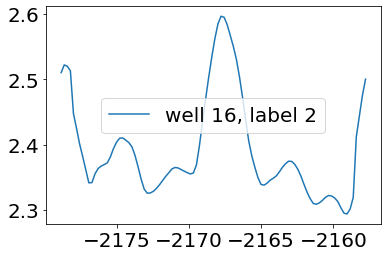

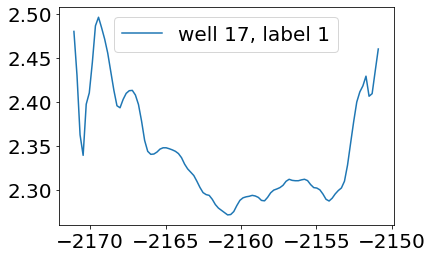

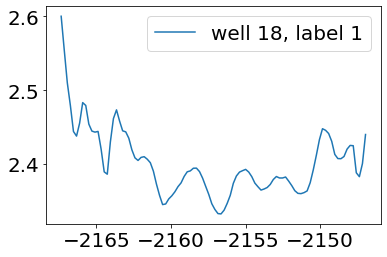

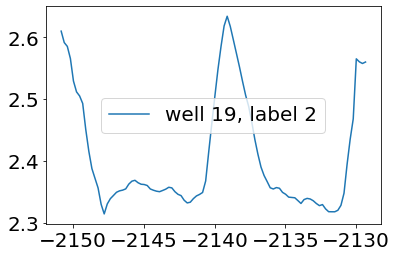

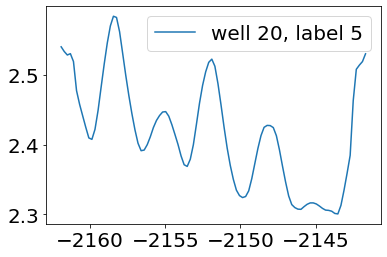

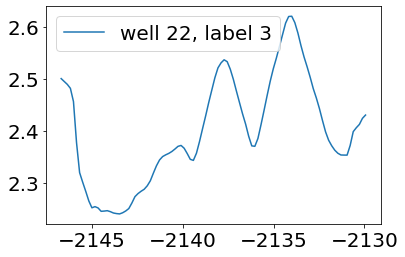

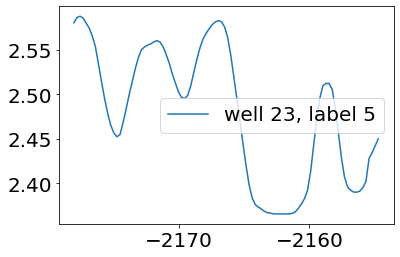

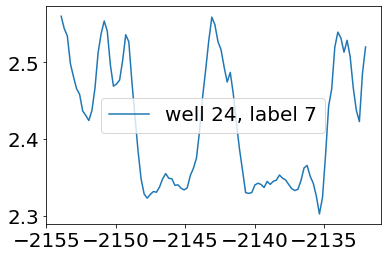

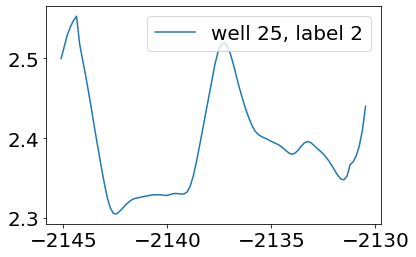

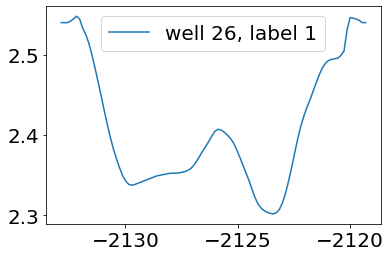

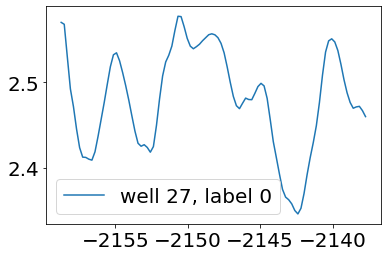

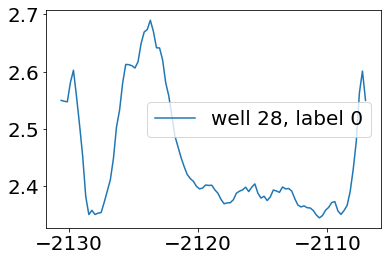

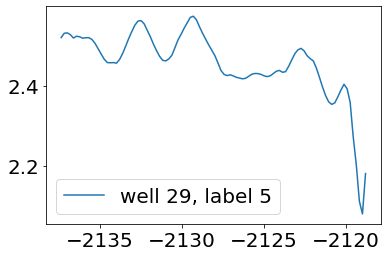

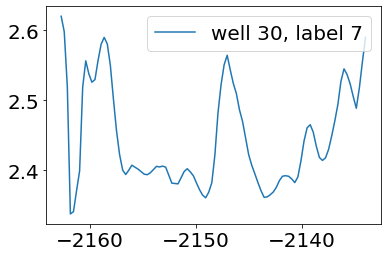

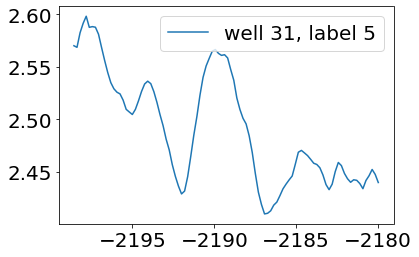

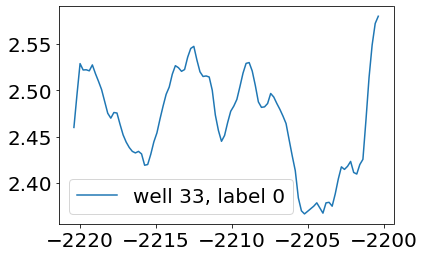

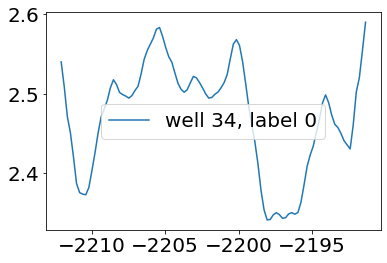

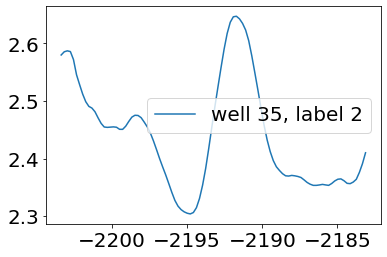

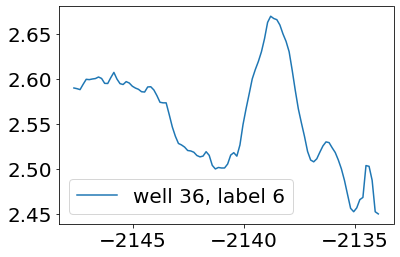

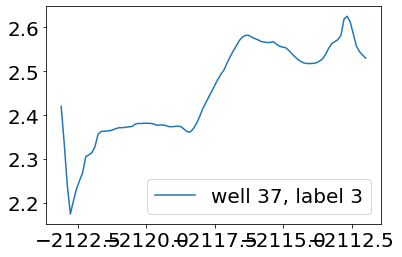

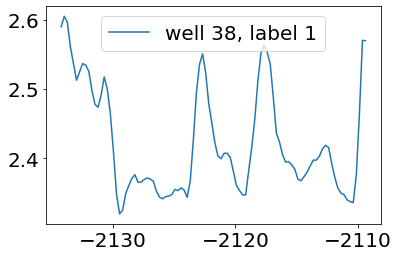

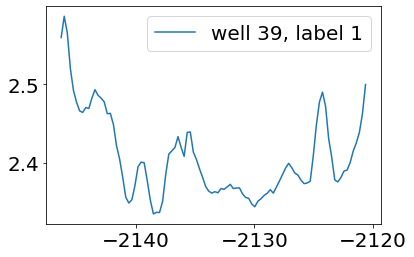

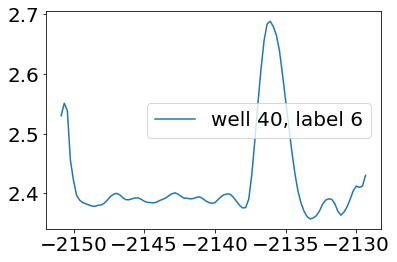

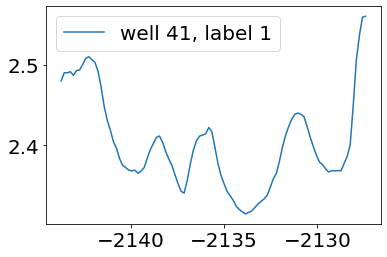

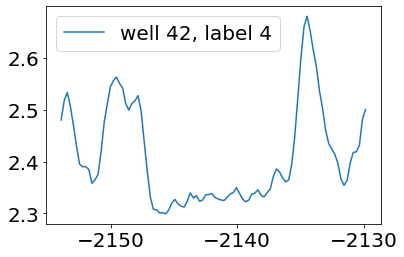

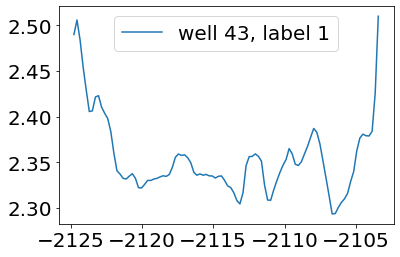

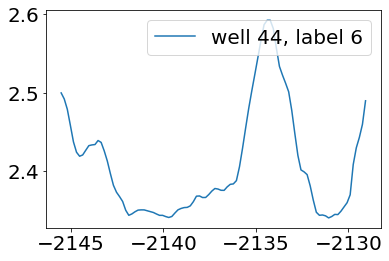

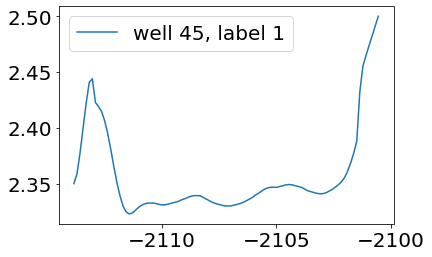

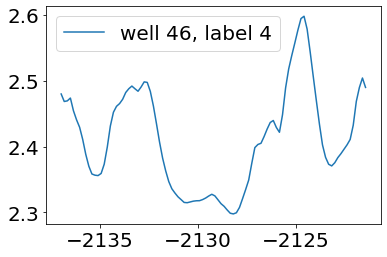

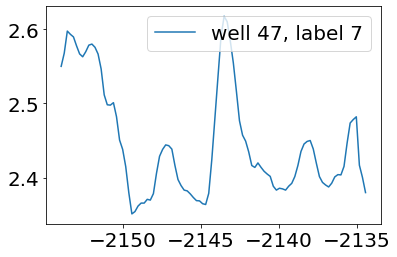

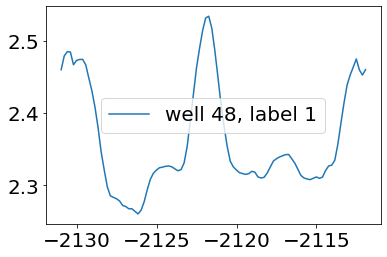

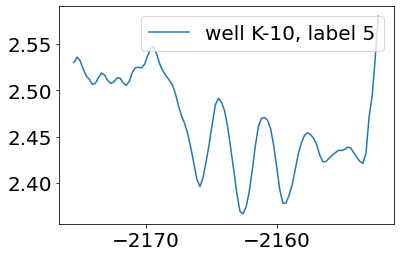

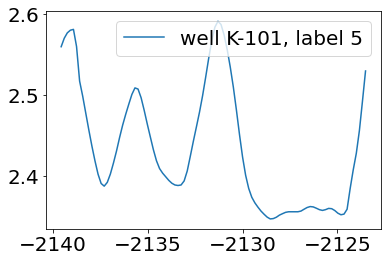

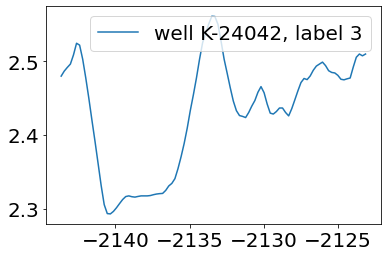

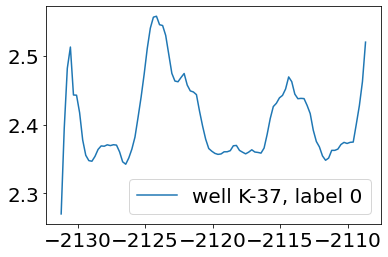

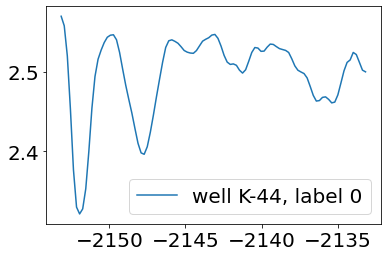

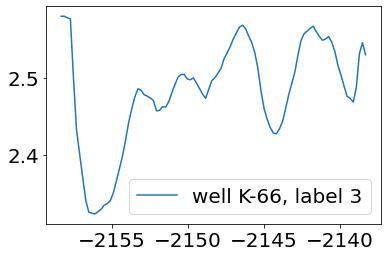

In [11]:
for i in range(data.shape[0]):
    plt.plot(data[i, 0], data[i, 1], label = 'well '+str(target_layers.iloc[i]['Well identifier'])+', label '+str(cluster_alg.labels_[i]))
    plt.legend()
    plt.savefig(str(cluster_alg.labels_[i])+'-'+str(target_layers.iloc[i]['Well identifier'])+'.png')
    plt.show()

# 2 задача: разделение участков кривых на кластеры

Сначала немного обработаем кривые: разделим кривую на 200 точек

In [12]:
data_ = []
z_ = []
for well_index in range(len(well_idx)):
    las = lasio.read(os.path.join(DATA_DIR, f"{target_layers.iloc[well_index]['Well identifier']}_continuous.las"))
    target_layer_idx = np.where((las['Z'] < target_layers.iloc[well_index].upper) & (las['Z'] > target_layers.iloc[well_index].lower))
    data_interp = interpolation.interpolate_lin(las["Z"][target_layer_idx], las["GGKP"][target_layer_idx], 200)
    data_.append(data_interp[1])
    z_.append(data_interp[0])

data = np.empty(len(data_), dtype=object)
z = np.empty(len(z_), dtype=object)
for i, sublist in enumerate(data_):
    data[i] = np.array(sublist)
for i, sublist in enumerate(z_):
    z[i] = np.array(sublist)    
data = np.vstack(data)
z = np.vstack(z)

Делаем разбиение кривой. функция сначала делает усреднение по t_ir точкам и вычитает из текущего массива данных усредненыый. По сути это эквивалентно
обрезанию низких частот в фурье. После этого она проводит усреднение по t_uv точкам, что эквивалентно обрезанию высоких
частот фурье. В конце она смотрит пересечение результата с 0 и выдает координаты этих пересечений. Эти пересечения
 довольно хорошо совпадают с разбиением на участки от геолога.

In [13]:
def splitting(z, ggkp, t_ir=67, t_uv=6):
    data_size = len(z)
    average_ggkp = np.zeros(data_size)

    # обрезаем низкие частоты
    for ind in range(data_size):
        average_ggkp[ind] = np.average(ggkp[max(0, ind - int(t_ir / 2)):min(ind + int(t_ir / 2), data_size)])
    not_ir_ggkp = ggkp - average_ggkp

    # обрезаем высокие частоты
    not_ir_uv_ggkp = np.zeros(data_size)
    for ind in range(data_size):
        not_ir_uv_ggkp[ind] = np.average(not_ir_ggkp[max(0, ind - int(t_uv / 2)):min(ind + int(t_uv / 2), data_size)])

    # ищем пересечения с 0 -- они будут нашими границами участков классов
    borders = np.zeros(0)
    for ind in range(1, data_size):
        if not_ir_uv_ggkp[ind - 1] * not_ir_uv_ggkp[ind] < 0:
            borders = np.append(borders, z[ind])
    return borders

In [14]:
split_points = []
for i in range(len(data[0])):
    split = splitting(z[0],data[0])
    split_point = 0
    for k in range(split.shape[0]):
        if z[0][i] == split[k]:
            split_point = 1
    split_points.append(split_point)
print(split_points)
    
    

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]


Разделим массив: линии раздела проходят по тем точкам, которые возвращает splitting

In [15]:
data_redone = []
for i in range(len(data[0])):
    split = splitting(z[0],data[0])
    split_point = data[0][i]
    for k in range(split.shape[0]):
        if z[0][i] == split[k]:
            split_point = 0
    data_redone.append(split_point)
from itertools import takewhile  
def split0(a): 
    it = iter(a) 
    return [[x for x in takewhile(bool, it)] for _ in range(a.count(0) + 1)]

data_redone = split0(data_redone)

data_new= np.empty(len(data_redone), dtype=object)
for i, sublist in enumerate(data_redone):
    data_new[i] = np.array(sublist)  
#print(data_new)
#print(len(data_new[2]))

Теперь, проверив, что у нас произошло разделение в одной из кривой, делаем разделение во всех кривых: все кривые делим на куски, согласно нашему алгоритму, собираем эти куски как отдельные объекты и уже их кластеризуем. (Примечание: слишком маленькие куски, где меньше 5 точек, мы опустим и не будем маркировать)

In [16]:
data_redone_true = []
z_redone_true = []
for j in range(len(data)):
    data_redone = []
    z_redone = []
    for i in range(len(data[j])):
        split = splitting(z[j],data[j])
        split_point_data = data[j][i]
        split_point_z = z[j][i]
        for k in range(split.shape[0]):
            if z[j][i] == split[k]:
                split_point_data = 0
                split_point_z = 0
        data_redone.append(split_point_data)
        z_redone.append(split_point_z)
    data_redone_local = split0(data_redone)
    z_redone_local = split0(z_redone)
    for k in range(len(data_redone_local)):
        data_redone_true.append(data_redone_local[k])
        z_redone_true.append(z_redone_local[k])
data_new= np.empty(len(data_redone_true), dtype=object)
z_new= np.empty(len(z_redone_true), dtype=object)
for i, sublist in enumerate(data_redone_true):
    data_new[i] = np.array(sublist)  
for i, sublist in enumerate(z_redone_true):
    z_new[i] = np.array(sublist)  

data_new_new= []
z_new_new= []
for data_iter in data_new:
    if data_iter.shape[0] > 5:
        data_new_new.append(data_iter)

for z_iter in z_new:
    if z_iter.shape[0] > 5:
        z_new_new.append(z_iter)
pair_of_elements = []

data_new_newinterp = np.empty(len(data_new_new), dtype=object)
for k in range (len(data_new_new)): 
    data_new_newinterp[k] = interpolation.interpolate_lin(z_new_new[k], data_new_new[k], 6)[0]
data_new_newinterp = np.vstack(data_new_newinterp)

print(data_new_newinterp.shape)

(390, 6)


Обучаем на KMeans и ищем наиболее оптимальное число кластеров (как и в первой задаче, это то число кластеров, на котором silhouette score максимальный

In [17]:
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import mahalanobis
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_new_newinterp)

silhouette = []
for k in range (8, 20, 1):
    
    kmeans = KMeans(n_clusters=k, random_state=42)
    silhouette_local = silhouette_score(data_new_newinterp, kmeans.fit_predict(data_new_newinterp))
    silhouette.append(silhouette_local)
# Print the cluster labels
print("Max silhouette_score", max(silhouette))
print("Max silhouette_score on number of clusters:", silhouette.index(max(silhouette)) + 8)
kmeans = KMeans(n_clusters= silhouette.index(max(silhouette)) + 8, random_state=42).fit(data_new_newinterp)
labels = kmeans.labels_
print("Cluster labels:", labels)

Max silhouette_score 0.5304736553393684
Max silhouette_score on number of clusters: 11
Cluster labels: [ 6  5  5  5  5  1  1  5  5  5  5  5  1  1  1  6  6  6  5  5  5  5  6  6
  6  6  5  5  5  5  5  5  5  1  1  1  1  5  5  5  1  1  1  1  1  1  1  4
  4  4  1  1  1  1  1  1  1  1  4  4  4  4  4  4  8  4  8  8  8  8  2  2
 10  1  1  1  4  4  4  4  4  8  8  8  8  8  8  8  2  2  2  2 10  5  5  5
  5  1  1  1  4  4  4  4  4  8  8  2  2  2  8  8  8  2  2  2  2  2  2 10
 10 10 10 10  7  7  7  7  4  4  4  4  8  8  8  2  2 10 10  7  7  0  0  0
  0  2  2 10 10 10 10  7  7  7  1  1  4  4  4  8  8  2  2  2  3  3  3  6
  6  6  6  6  6  6  6  9  9  9  9  9  9  9  9  3  3  3  9  9  3  3  3  3
  3  3  6  3  3  3  3  3  6  6  6  6  8  8  8  8  8  2  2  2  2  7  7  7
  7  7  7  0  0  0 10 10  7  7  7  0  0  0  8  8  8  2  2  2 10 10 10  7
  7  7  4  4  8  8  8  8  8  2  2 10 10  8  2  2  2  2  2 10 10 10  4  4
  4  8  8  8  2  2  2 10  7  7  7  7  7  0  0  0  0  0  0  0  0  8  8  8
  8  2  2  2 10 10  0

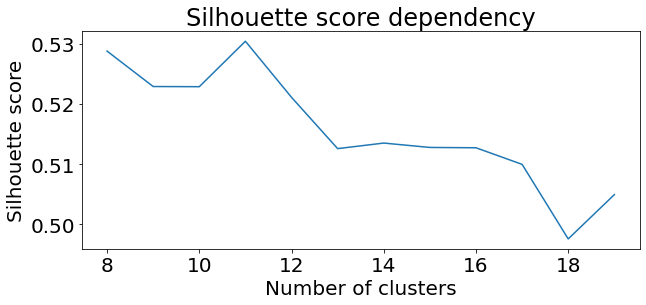

In [18]:
plt.figure(figsize=(10, 4))
x = np.array([i for i in range (8, 20, 1)])
y = np.array(silhouette)
plt.title("Silhouette score dependency")
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette score")
plt.plot(x, y)
plt.savefig("silhouette_score.png")
plt.show()

Далее, нанесём эту разметку на наши кривые, пометив каждый кластер определенным цветом

In [19]:
background_start = []
background_end = []
for k in range(len(z_new_new)):
    background_start.append(z_new_new[k][0])
    background_end.append(z_new_new[k][-1])

In [20]:
colors = {
    0: 'red',
    1: 'blue',
    2: 'green',
    3: 'yellow',
    4: 'orange',
    5: 'maroon',
    6: 'cyan',
    7: 'magenta',
    8: 'lime',
    9: 'pink',
    10: 'teal',
    11: 'brown'
}

colors[list(colors.keys())[4]]

'orange'

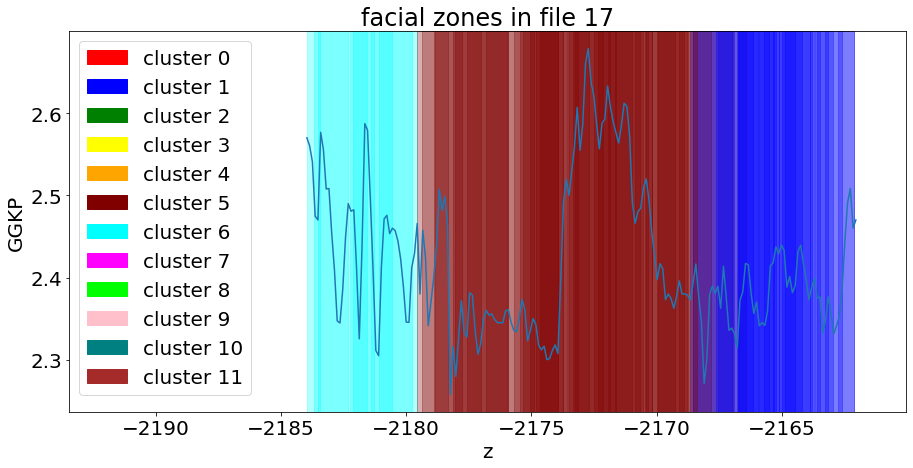

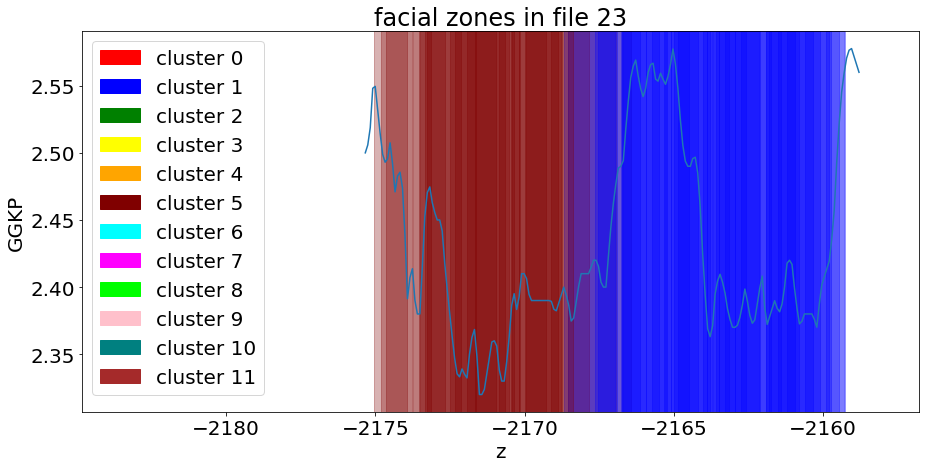

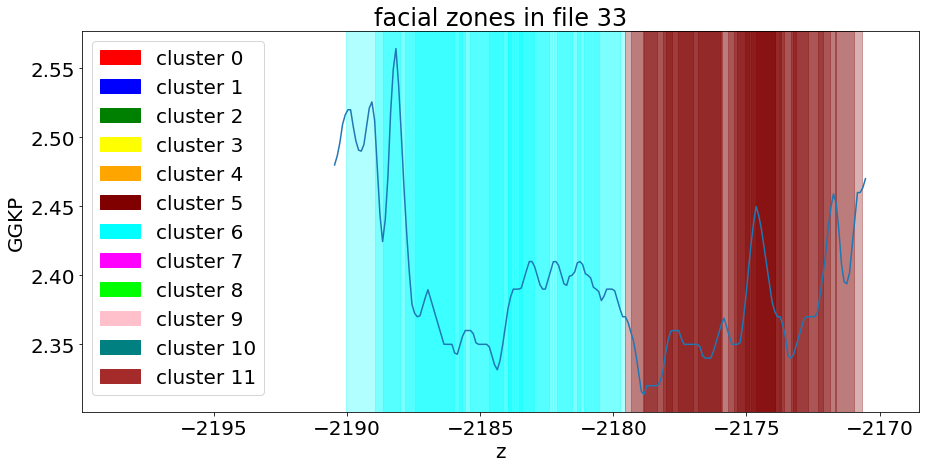

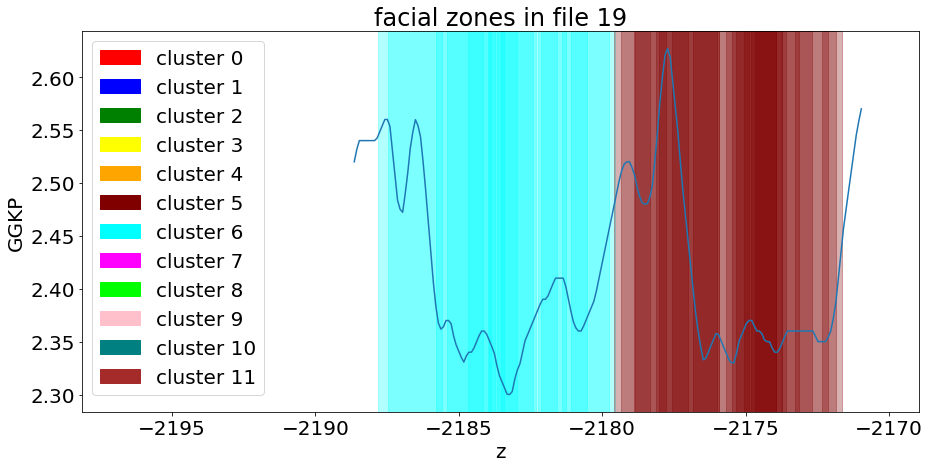

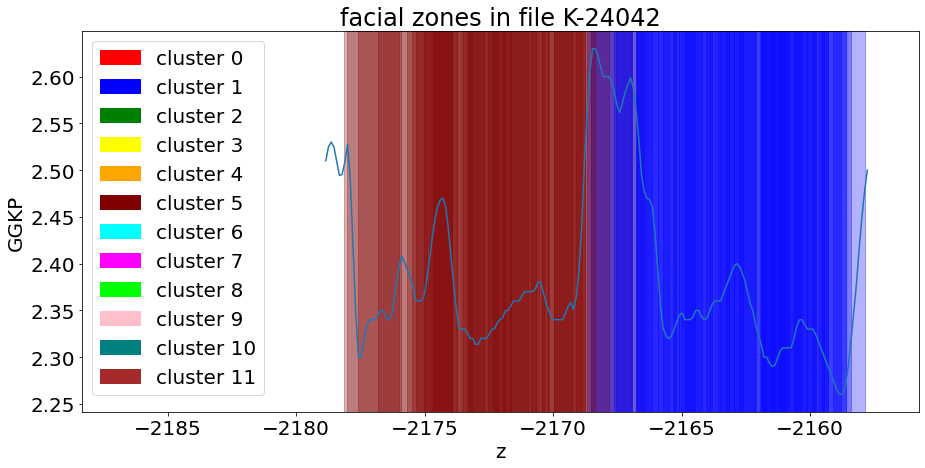

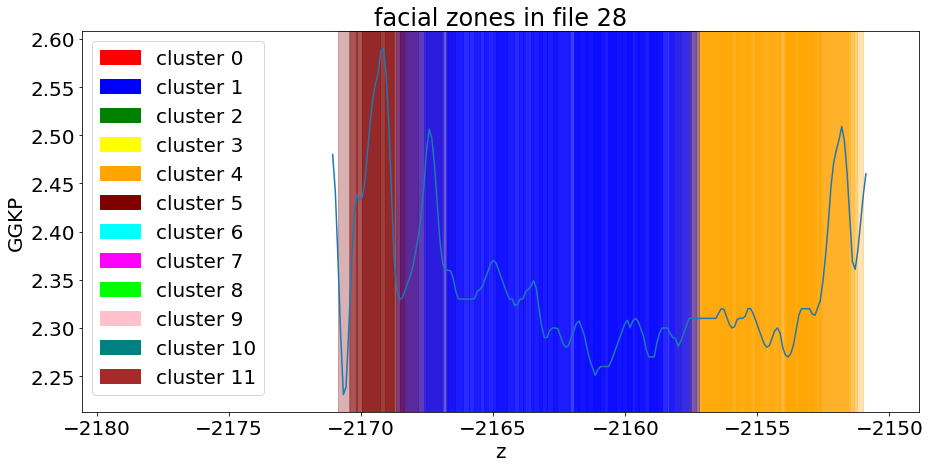

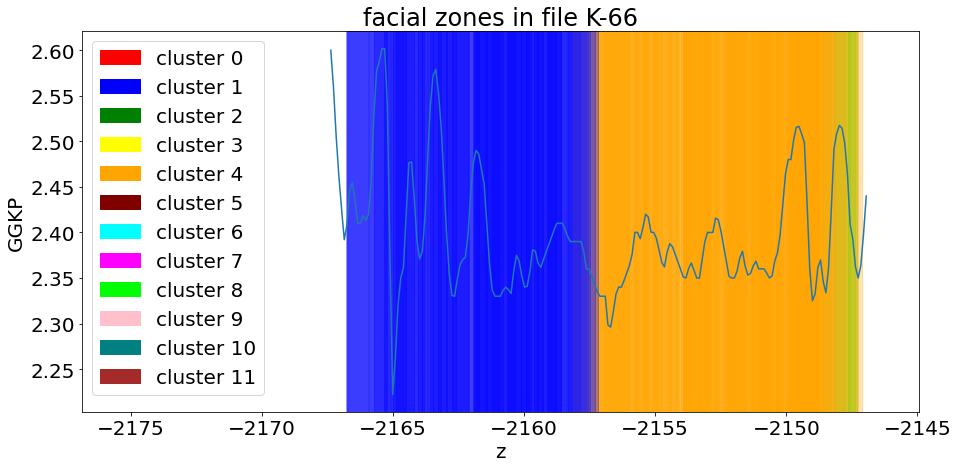

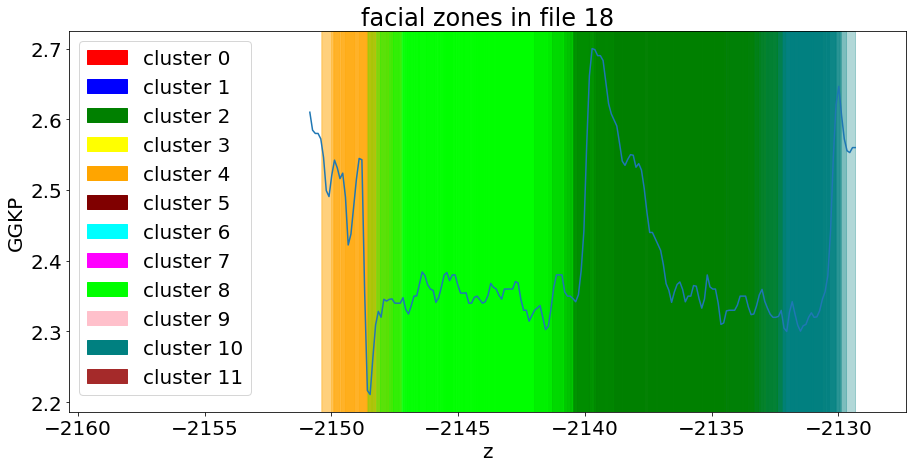

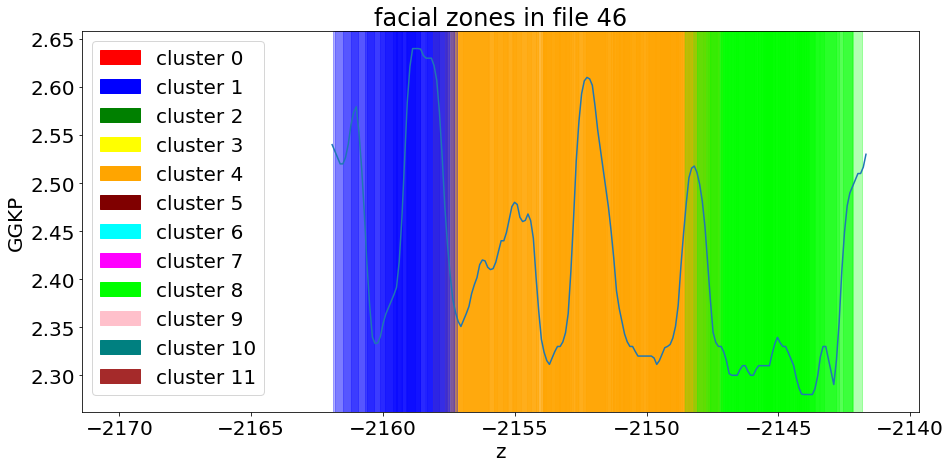

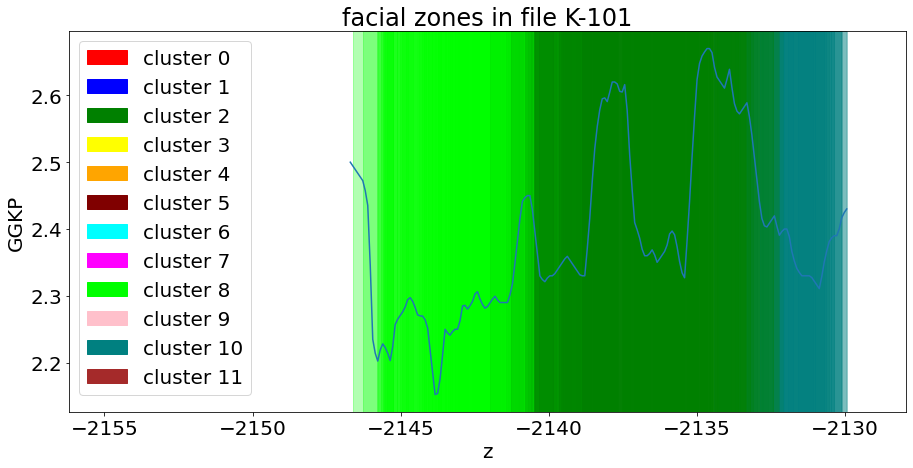

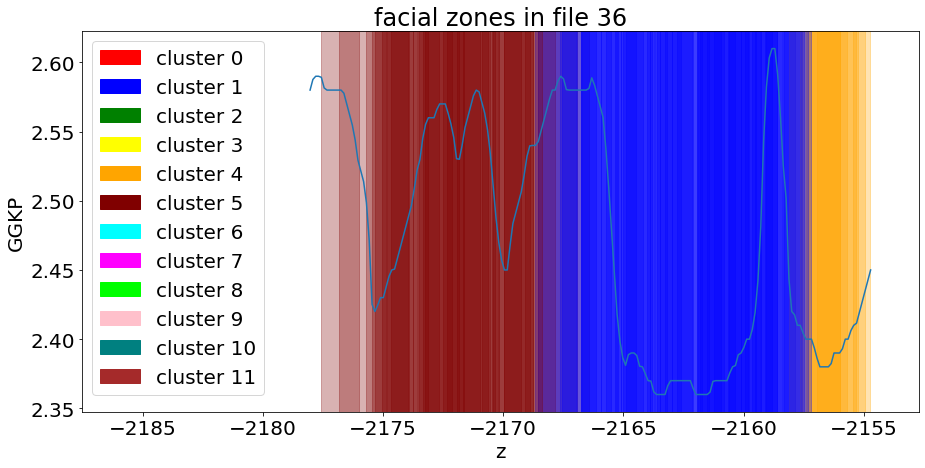

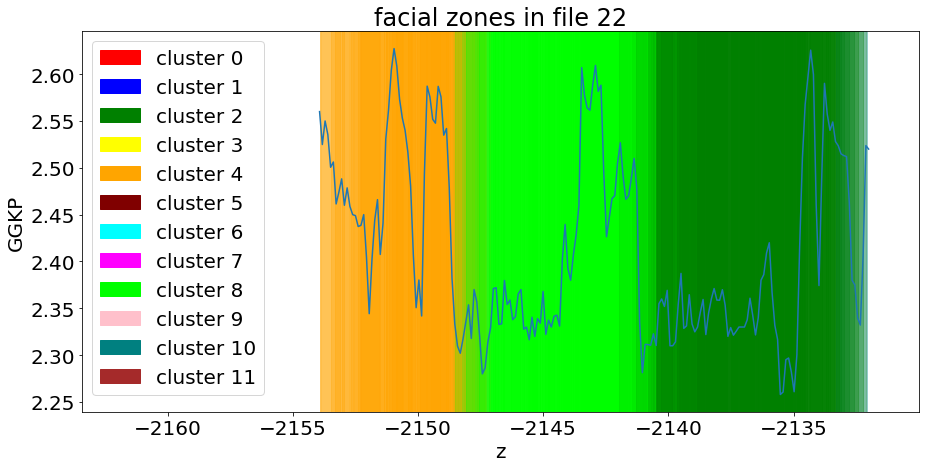

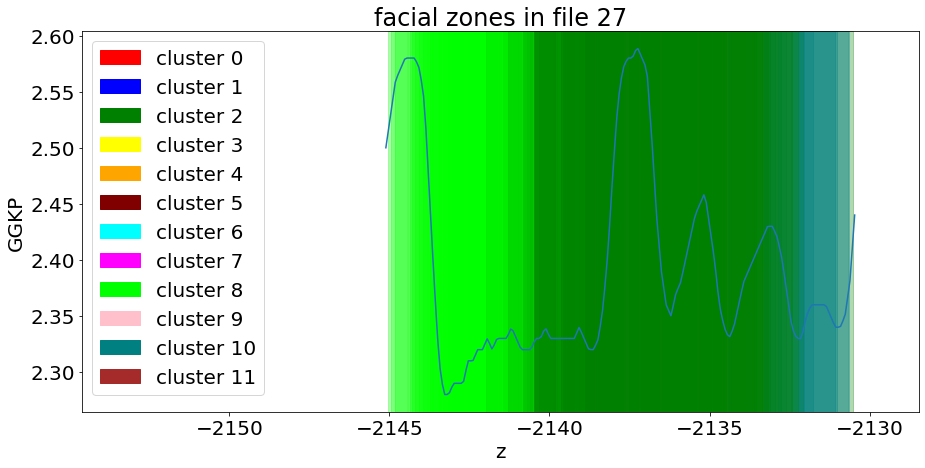

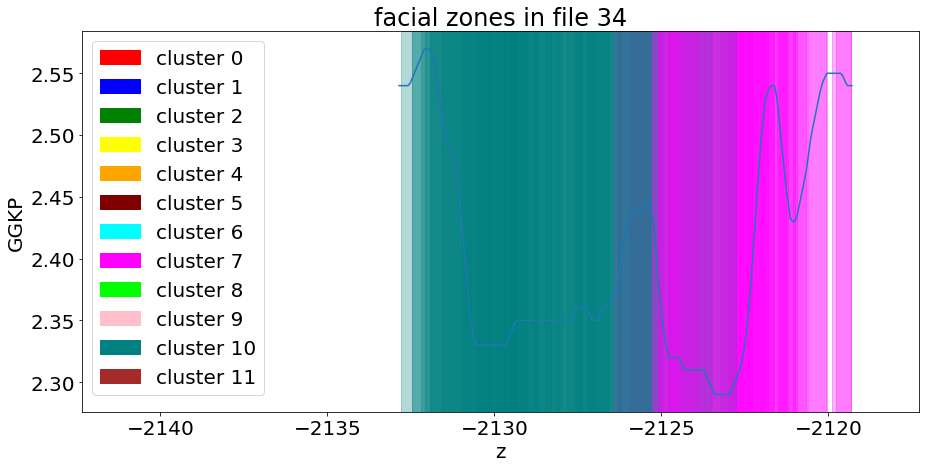

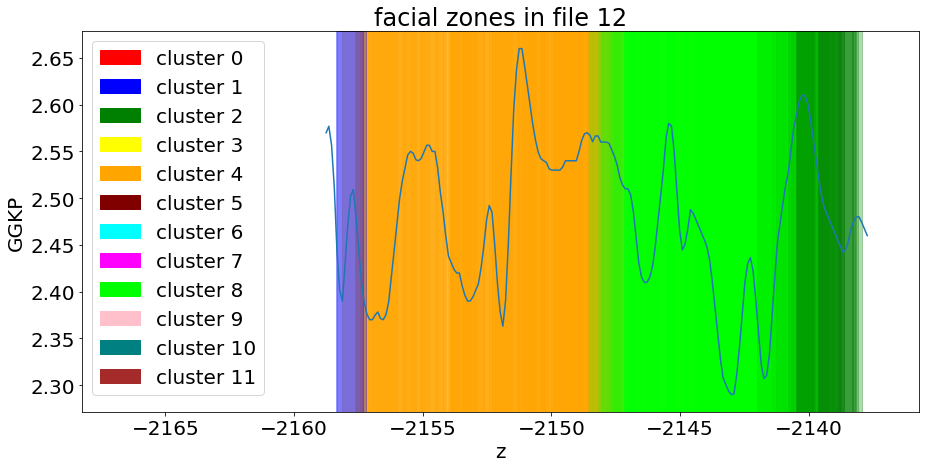

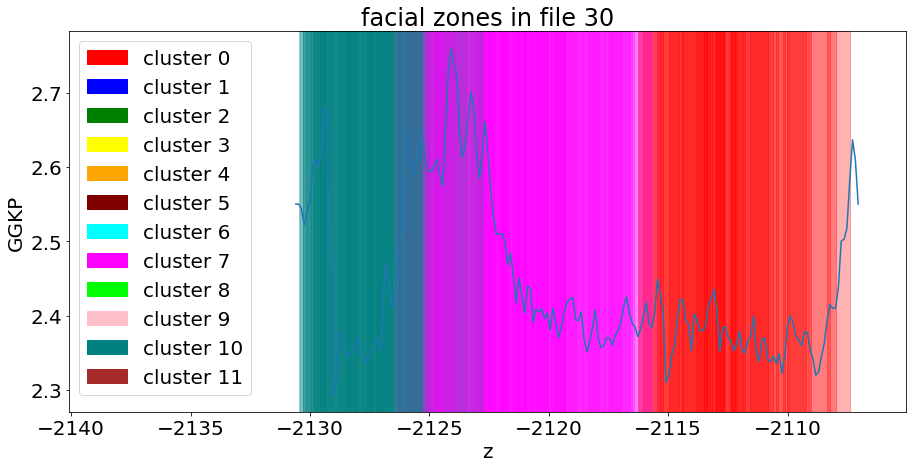

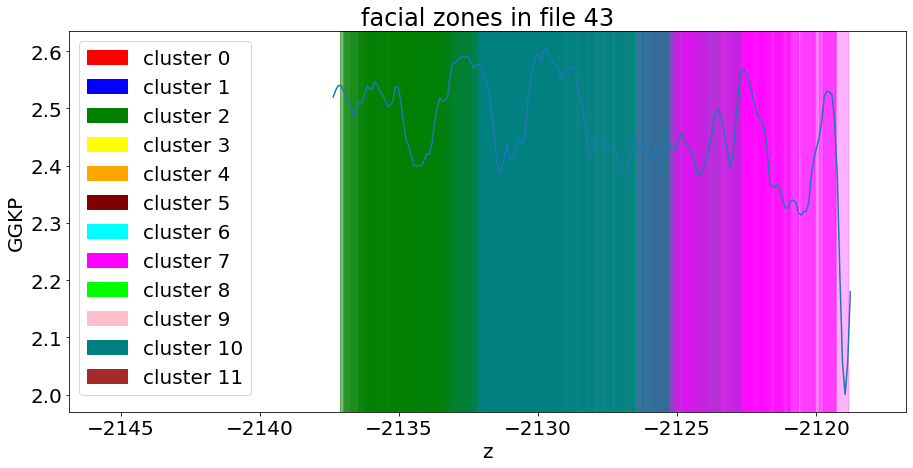

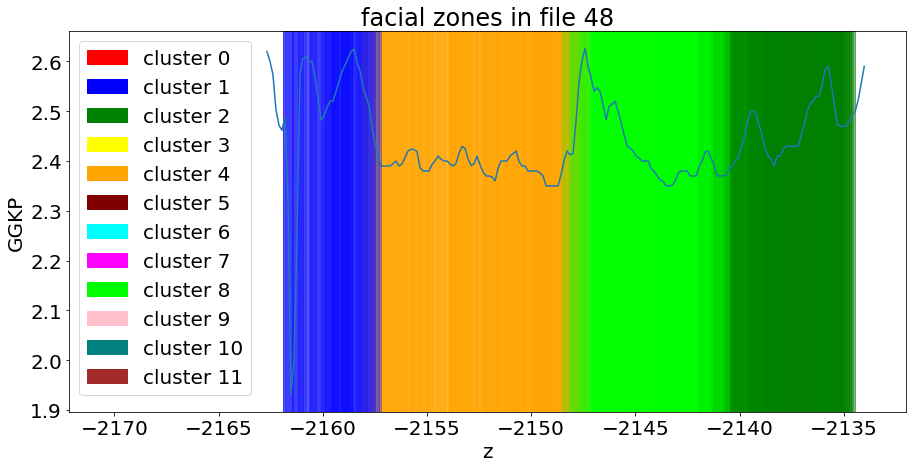

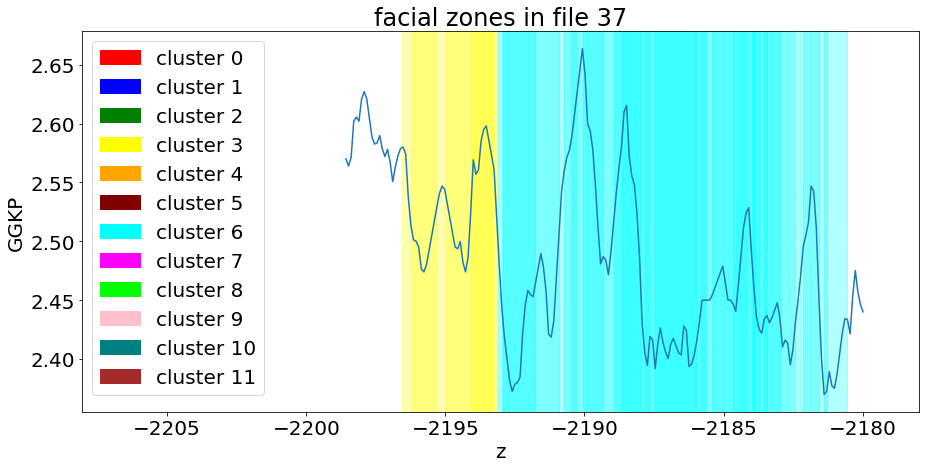

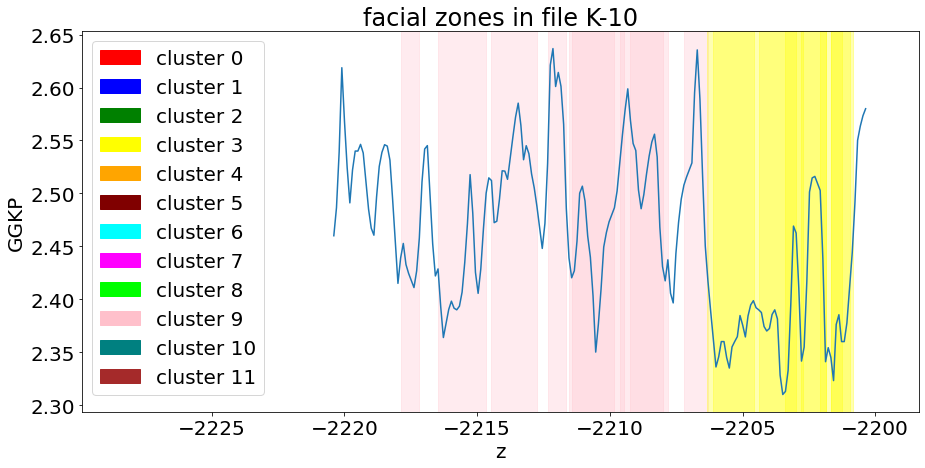

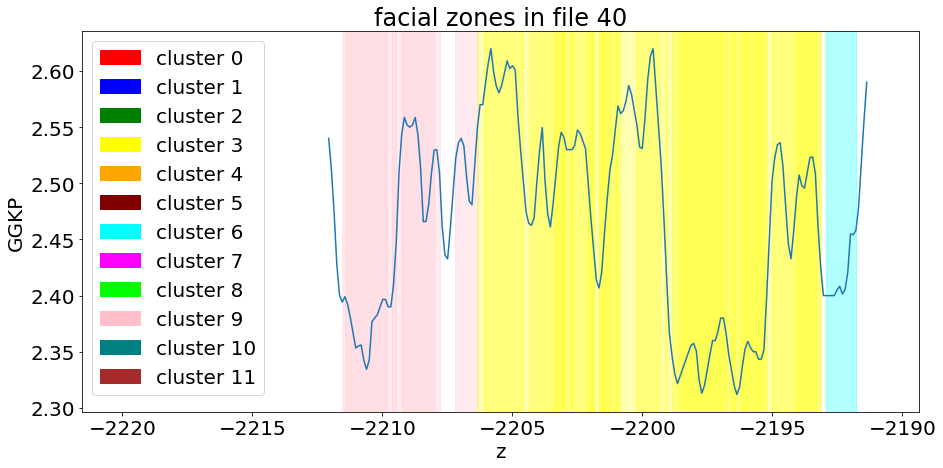

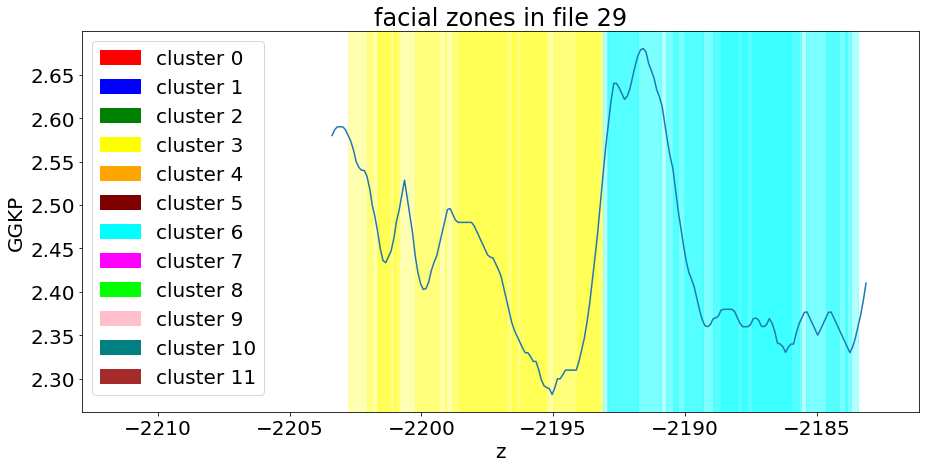

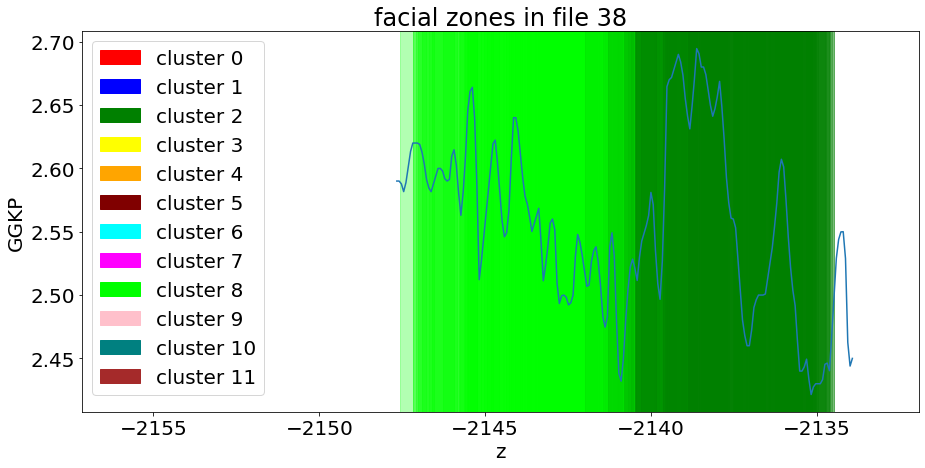

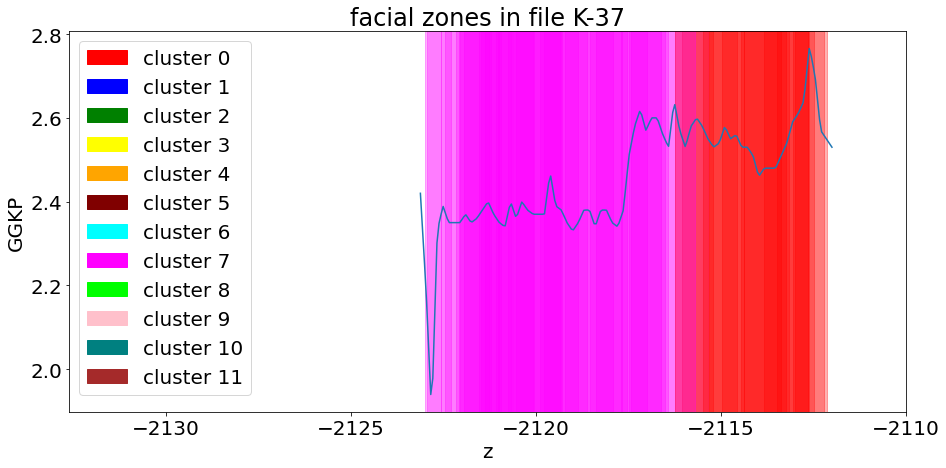

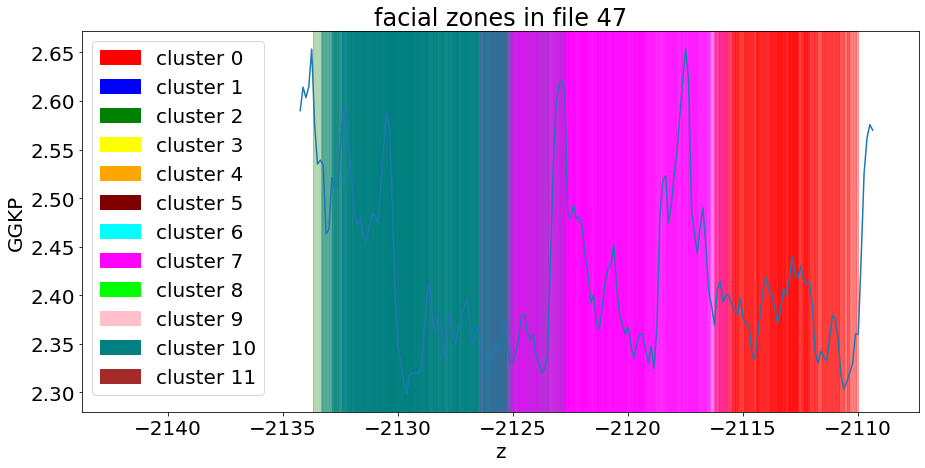

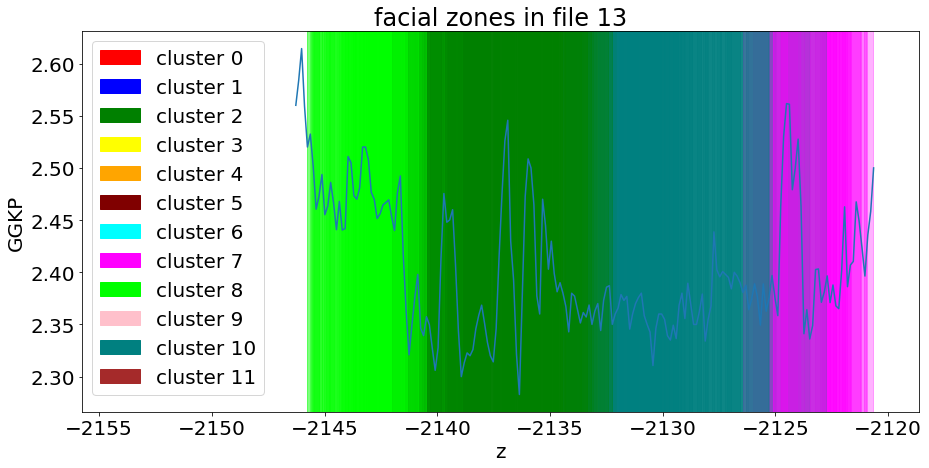

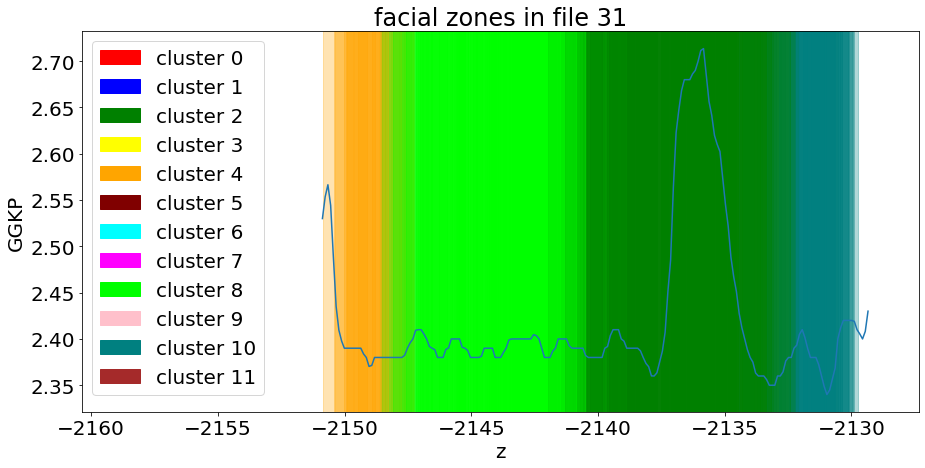

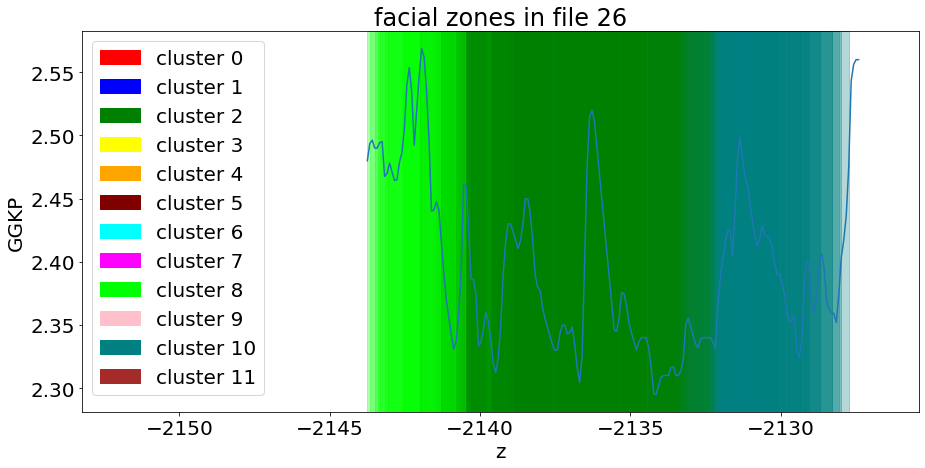

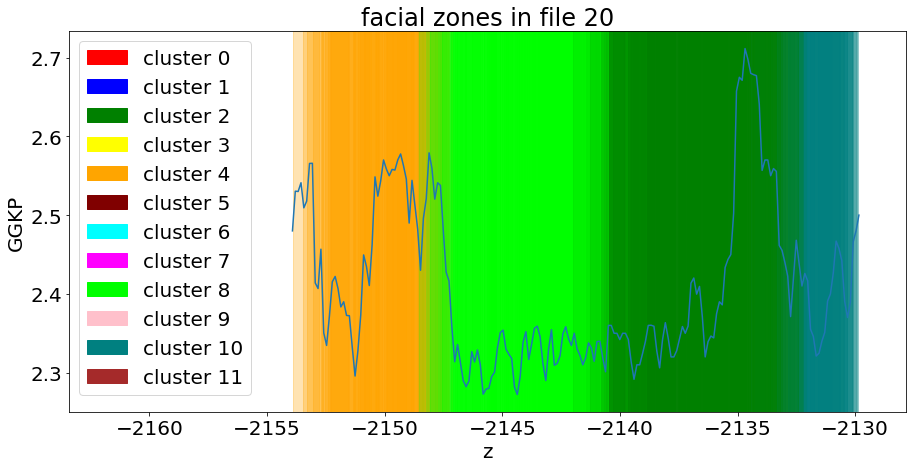

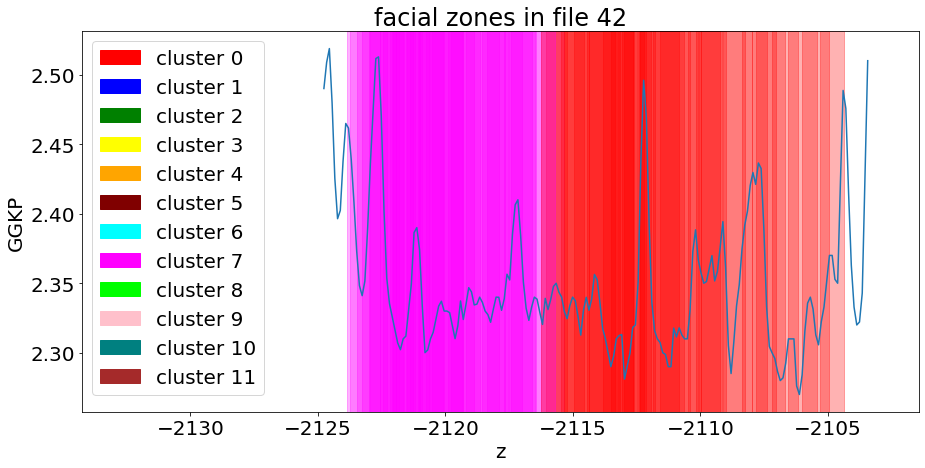

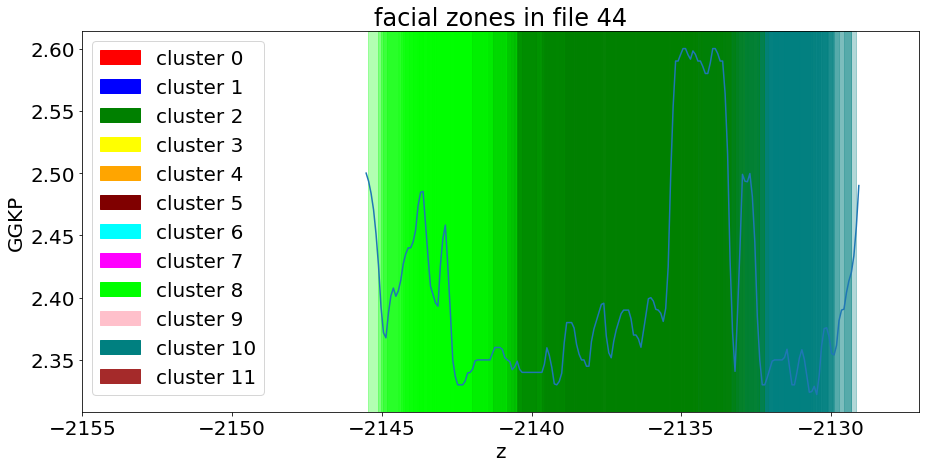

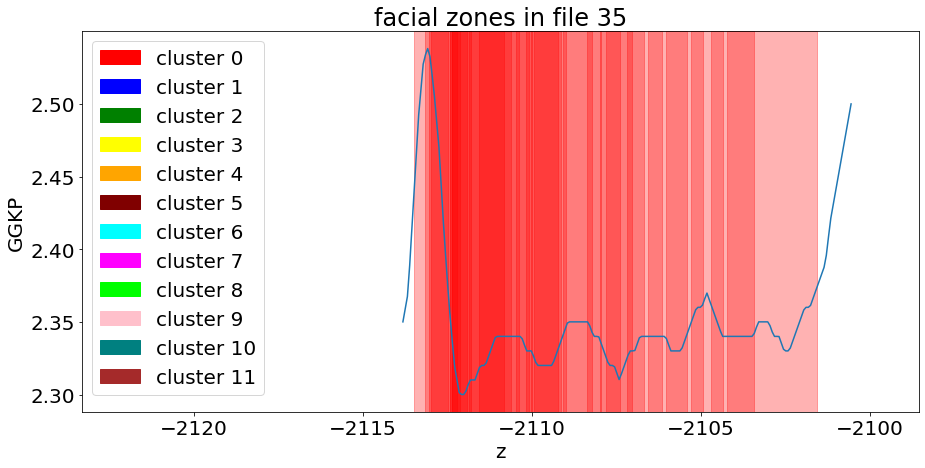

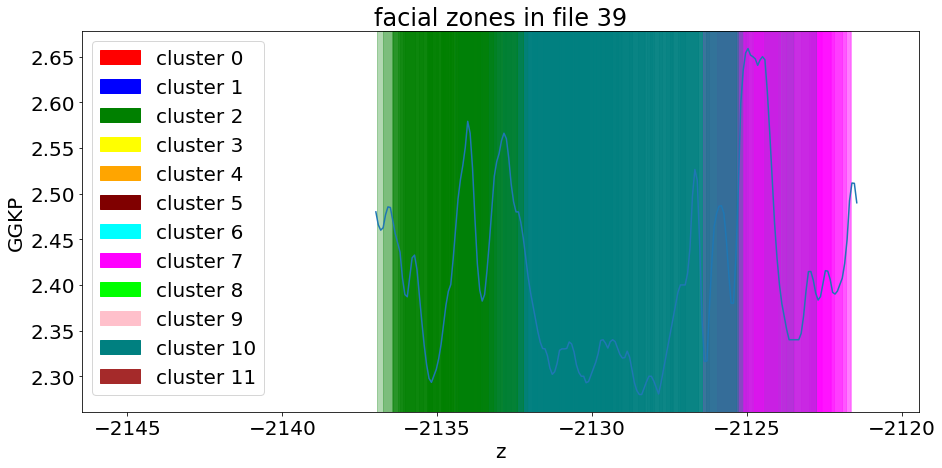

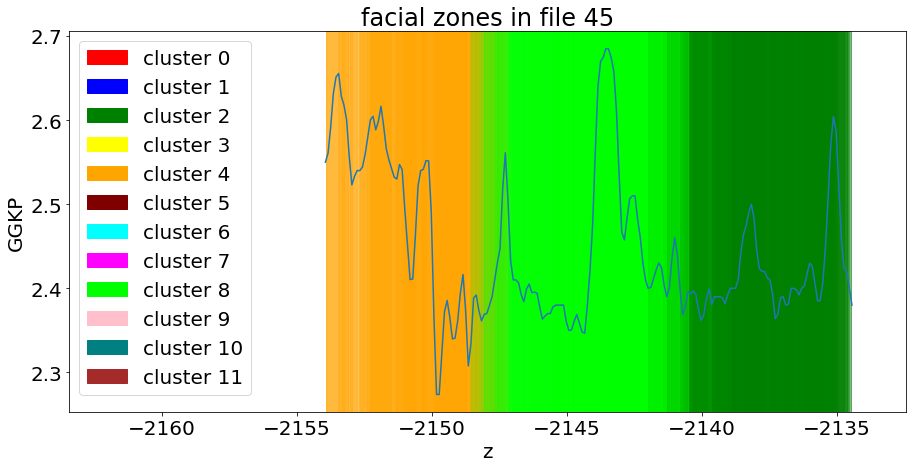

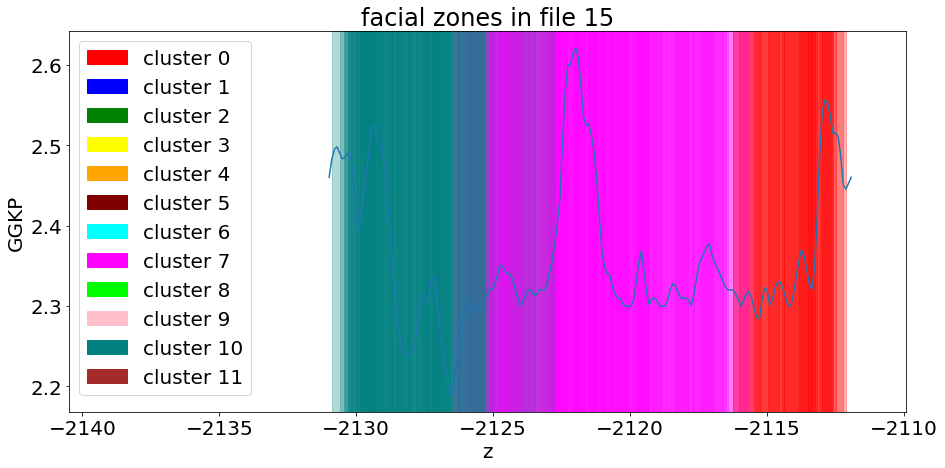

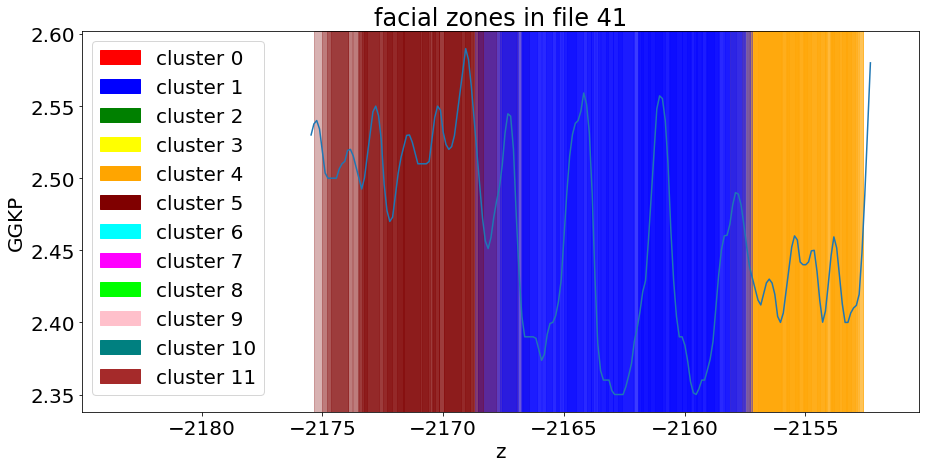

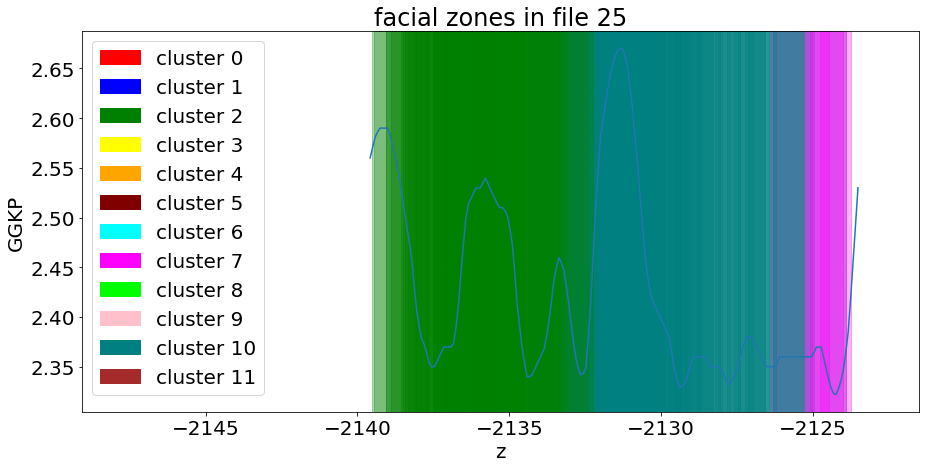

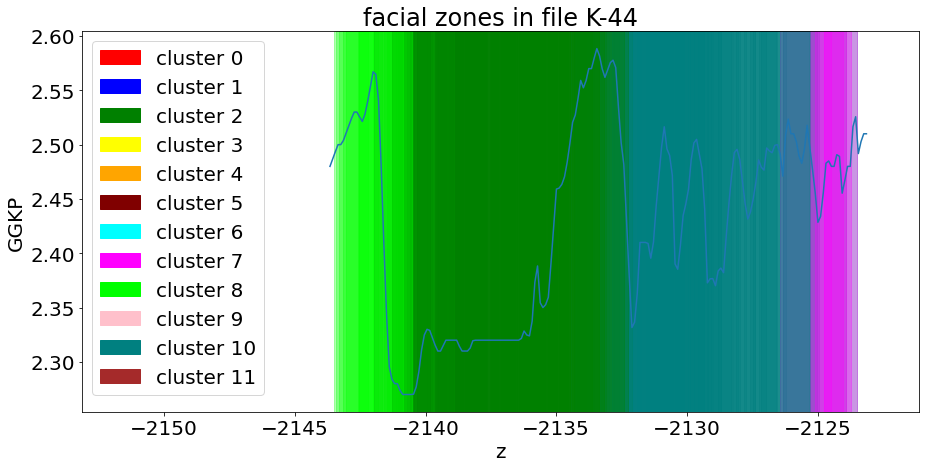

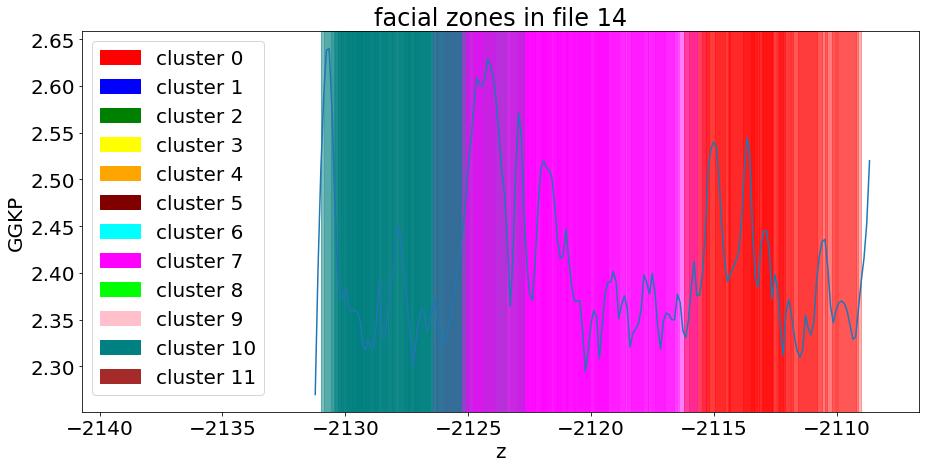

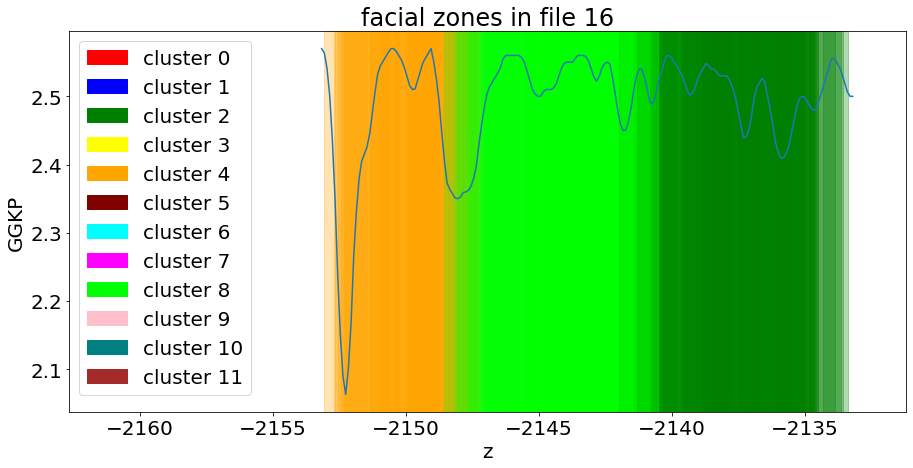

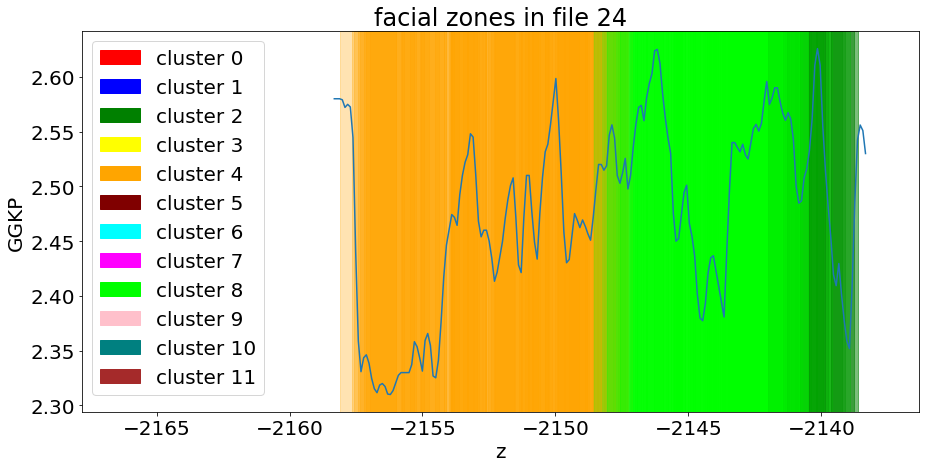

In [21]:
import matplotlib.patches as mpatches
for files in range(len(well_idx)):
    plt.figure(figsize=(15, 7))
    plt.plot(z[files], data[files])
    for k in range(len(z_new_new)):
        if (min(z[files]) < background_start[k]) and (max(z[files]) > background_end[k]):
            color = colors[list(colors.keys())[labels[k]]]
            plt.axvspan(background_start[k], background_end[k], color=color, alpha=0.3)
    plt.title("facial zones in file "+list(well_idx)[files])
    plt.xlim([min(z[files]) - 9.5, max(z[files]) + 2])
    plt.xlabel("z")
    plt.ylabel("GGKP")
    patches = []
    for col in range(len(list(colors.keys()))):
         patches.append(mpatches.Patch(color= colors[list(colors.keys())[col]], label='cluster '+str(col)))
    plt.legend(loc="upper left", handles=patches,)
    plt.savefig("facial zones in file "+list(well_idx)[files]+".png")
    plt.show()

# Распределение новых данных по кластерам

Сначала распределим скважины

In [22]:

DATA_DIR = NEW_DATA_DIR
EXCEL_DIR = NEW_EXCEL_DIR
EXCEL = NEW_EXCEL

well_idx = []
for filename in os.listdir(DATA_DIR):
    well_idx.append(filename.split("_")[0])
well_idx = set(well_idx)



excel = pd.read_excel(EXCEL_DIR + EXCEL)

upper_bounds = excel.iloc[::2].copy()
upper_bounds.rename(columns={'Z': 'upper'}, inplace=True)
upper_bounds.drop(['Surface', 'MD'], inplace=True, axis=1)

lower_bounds = excel.iloc[1::2].copy()
lower_bounds.rename(columns={'Z': 'lower'}, inplace=True)
lower_bounds.drop(['Surface', 'MD'], inplace=True, axis=1)



target_layers = pd.merge(upper_bounds, lower_bounds, on='Well identifier', how='outer')
target_layers['Well identifier'] = target_layers['Well identifier'].astype(str)
target_layers = target_layers[target_layers['Well identifier'].isin(well_idx)]

In [23]:
data = []

interpol_func = interpolation.interpolate_lin_av
new_size = 100

for well_index in range(len(well_idx)):
    well_name = target_layers.iloc[well_index]['Well identifier']
    las = lasio.read(os.path.join(DATA_DIR, f"{target_layers.iloc[well_index]['Well identifier']}_continuous.las"))
    target_layer_idx = np.where((las['Z'] < target_layers.iloc[well_index].upper) & (las['Z'] > target_layers.iloc[well_index].lower))
    data_interp = interpol_func(las["Z"][target_layer_idx], las["GGKP"][target_layer_idx], new_size, width)
    data.append(np.stack(data_interp))

data = np.array(data)
print(data.shape)
new_data = np.empty((len(well_idx),101))
for i in range(len(well_idx)):
    new_data[i] = np.concatenate([[data[i, 0].mean()], data[i, 1]])
    new_data[i] -= new_data[i].mean()
    new_data[i] /= new_data[i].max()-new_data[i].min()
new_data.shape, data.shape

(8, 2, 100)


((8, 101), (8, 2, 100))

Распределение новых данных по скважинам

In [24]:
prediction1=cluster_alg.predict(new_data)
print(prediction1)

[2 2 1 2 2 1 1 2]


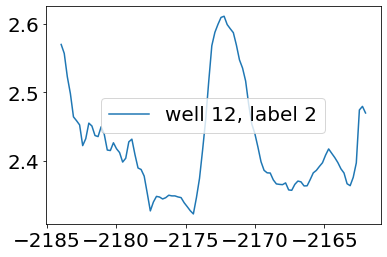

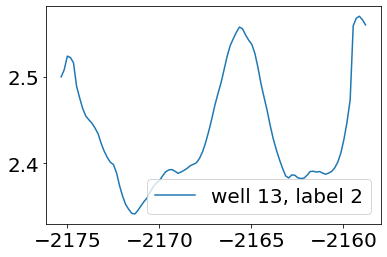

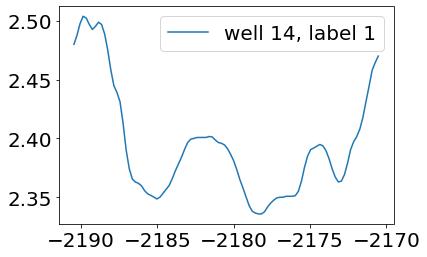

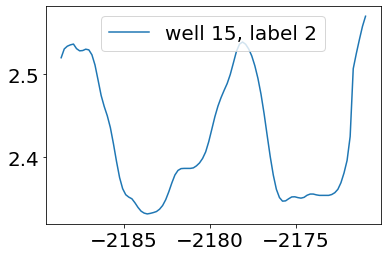

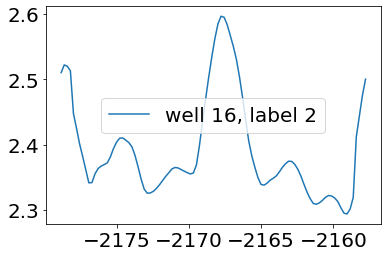

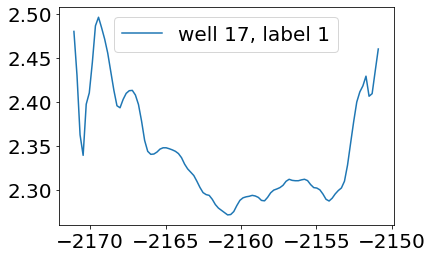

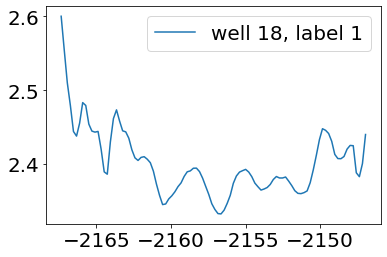

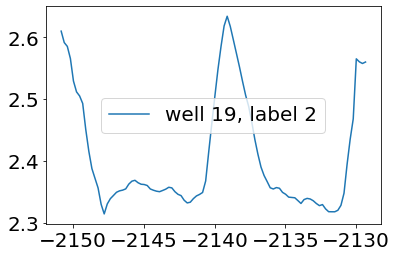

In [25]:
for i in range(data.shape[0]):
    plt.plot(data[i, 0], data[i, 1], label = 'well '+str(target_layers.iloc[i]['Well identifier'])+', label '+str(prediction1[i]))
    plt.legend()
    plt.savefig(str(cluster_alg.labels_[i])+'-'+str(target_layers.iloc[i]['Well identifier'])+'.png')
    plt.show()

# Предсказания для 2 части

Сначала немного обработаем кривые: разделим кривую на 200 точек

In [26]:
data_ = []
z_ = []
for well_index in range(len(well_idx)):
    las = lasio.read(os.path.join(NEW_DATA_DIR, f"{target_layers.iloc[well_index]['Well identifier']}_continuous.las"))
    target_layer_idx = np.where((las['Z'] < target_layers.iloc[well_index].upper) & (las['Z'] > target_layers.iloc[well_index].lower))
    data_interp = interpolation.interpolate_lin(las["Z"][target_layer_idx], las["GGKP"][target_layer_idx], 200)
    data_.append(data_interp[1])
    z_.append(data_interp[0])

data = np.empty(len(data_), dtype=object)
z = np.empty(len(z_), dtype=object)
for i, sublist in enumerate(data_):
    data[i] = np.array(sublist)
for i, sublist in enumerate(z_):
    z[i] = np.array(sublist)    
data = np.vstack(data)
z = np.vstack(z)

In [27]:
split_points = []
for i in range(len(data[0])):
    split = splitting(z[0],data[0])
    split_point = 0
    for k in range(split.shape[0]):
        if z[0][i] == split[k]:
            split_point = 1
    split_points.append(split_point)
print(split_points)
    

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]


Разделим массив: линии раздела проходят по тем точкам, которые возвращает splitting

In [28]:
data_redone = []
for i in range(len(data[0])):
    split = splitting(z[0],data[0])
    split_point = data[0][i]
    for k in range(split.shape[0]):
        if z[0][i] == split[k]:
            split_point = 0
    data_redone.append(split_point)
from itertools import takewhile  
def split0(a): 
    it = iter(a) 
    return [[x for x in takewhile(bool, it)] for _ in range(a.count(0) + 1)]

data_redone = split0(data_redone)

data_new= np.empty(len(data_redone), dtype=object)
for i, sublist in enumerate(data_redone):
    data_new[i] = np.array(sublist)  
#print(data_new)
print(len(data_new[2]))

0


In [29]:
data_redone_true = []
z_redone_true = []
for j in range(len(data)):
    data_redone = []
    z_redone = []
    for i in range(len(data[j])):
        split = splitting(z[j],data[j])
        split_point_data = data[j][i]
        split_point_z = z[j][i]
        for k in range(split.shape[0]):
            if z[j][i] == split[k]:
                split_point_data = 0
                split_point_z = 0
        data_redone.append(split_point_data)
        z_redone.append(split_point_z)
    data_redone_local = split0(data_redone)
    z_redone_local = split0(z_redone)
    for k in range(len(data_redone_local)):
        data_redone_true.append(data_redone_local[k])
        z_redone_true.append(z_redone_local[k])
data_new= np.empty(len(data_redone_true), dtype=object)
z_new= np.empty(len(z_redone_true), dtype=object)
for i, sublist in enumerate(data_redone_true):
    data_new[i] = np.array(sublist)  
for i, sublist in enumerate(z_redone_true):
    z_new[i] = np.array(sublist)  

data_new_new= []
z_new_new= []
for data_iter in data_new:
    if data_iter.shape[0] > 5:
        data_new_new.append(data_iter)

for z_iter in z_new:
    if z_iter.shape[0] > 5:
        z_new_new.append(z_iter)
pair_of_elements = []

data_new_newinterp = np.empty(len(data_new_new), dtype=object)
for k in range (len(data_new_new)): 
    data_new_newinterp[k] = interpolation.interpolate_lin(z_new_new[k], data_new_new[k], 6)[0]
data_new_newinterp = np.vstack(data_new_newinterp)

print(data_new_newinterp.shape)

(73, 6)


Предсказания для 2 части задачи:

In [30]:
print("Cluster labels:", kmeans.predict(data_new_newinterp))
labels = kmeans.labels_

Cluster labels: [ 6  5  5  5  5  1  1  5  5  5  5  5  1  1  1  6  6  6  5  5  5  5  6  6
  6  6  5  5  5  5  5  5  5  1  1  1  1  5  5  5  1  1  1  1  1  1  1  4
  4  4  1  1  1  1  1  1  1  1  4  4  4  4  4  4  8  4  8  8  8  8  2  2
 10]


In [31]:
background_start = []
background_end = []
print(len(z_new_new))
for k in range(len(z_new_new)):
    background_start.append(z_new_new[k][0])
    background_end.append(z_new_new[k][-1])

73


In [32]:
colors = {
    0: 'red',
    1: 'blue',
    2: 'green',
    3: 'yellow',
    4: 'orange',
    5: 'maroon',
    6: 'cyan',
    7: 'magenta',
    8: 'lime',
    9: 'pink',
    10: 'teal',
    11: 'brown'
}

colors[list(colors.keys())[4]]

'orange'

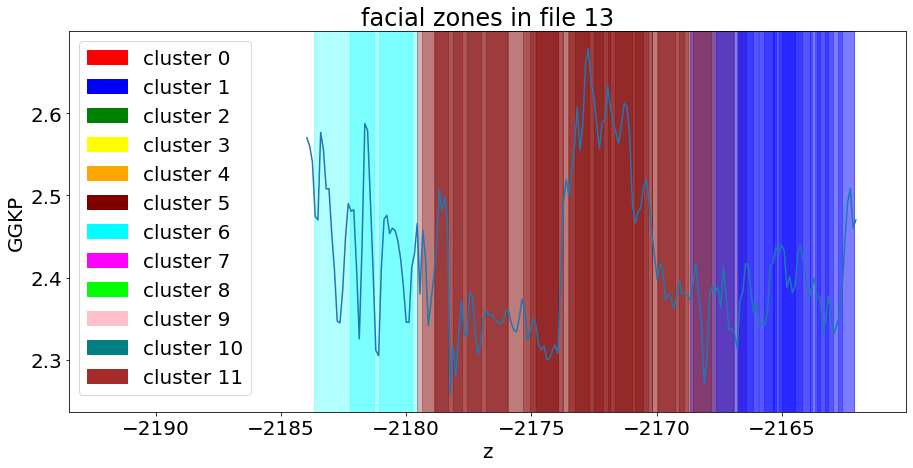

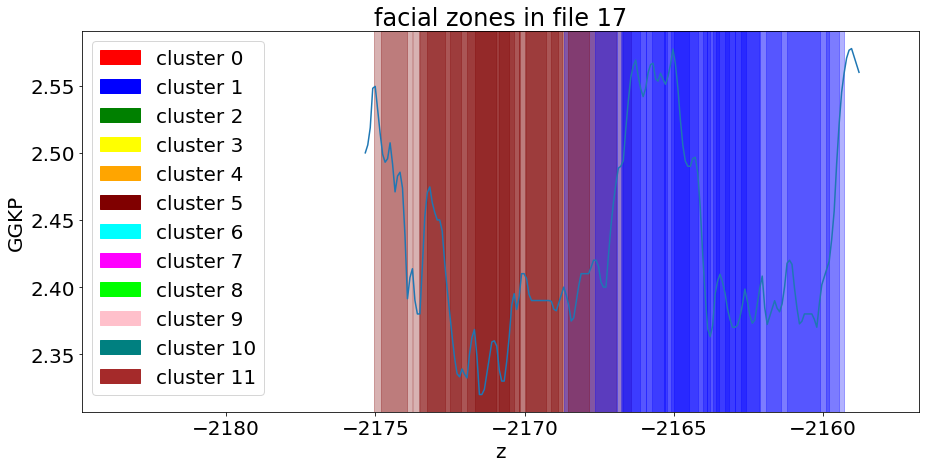

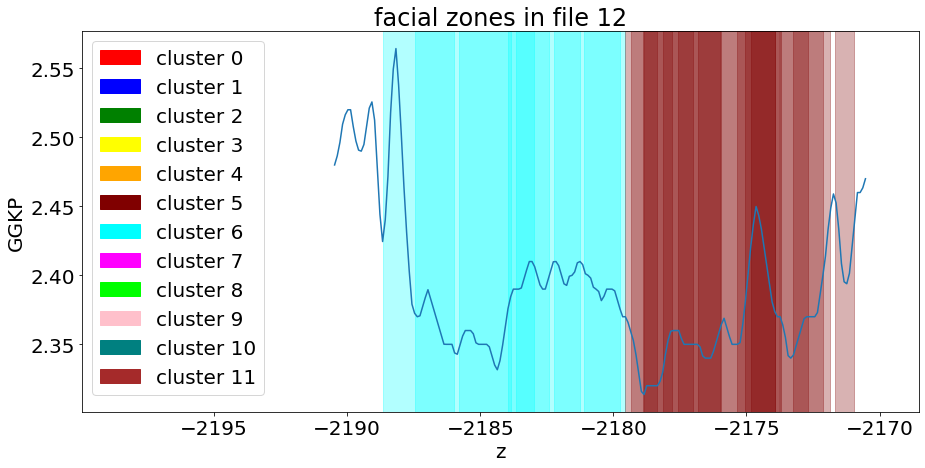

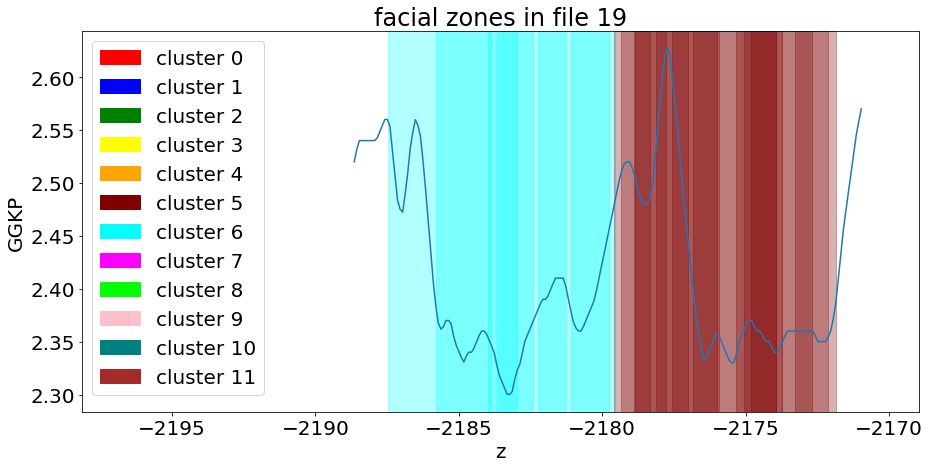

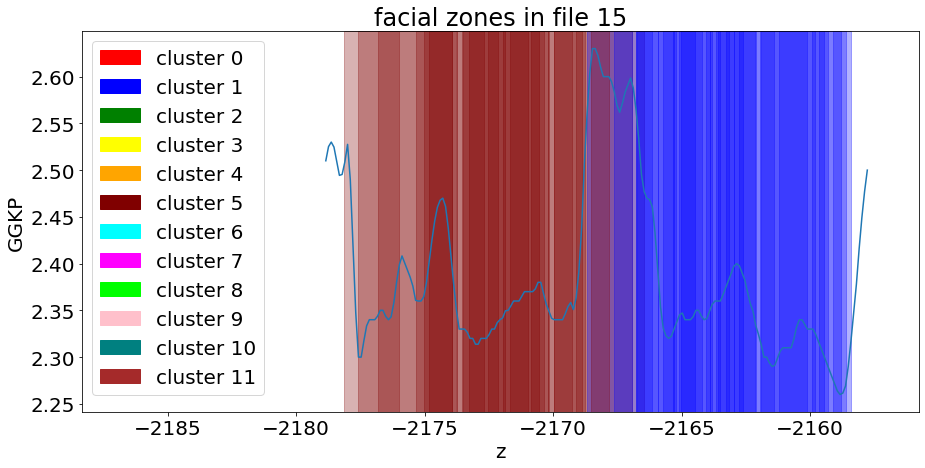

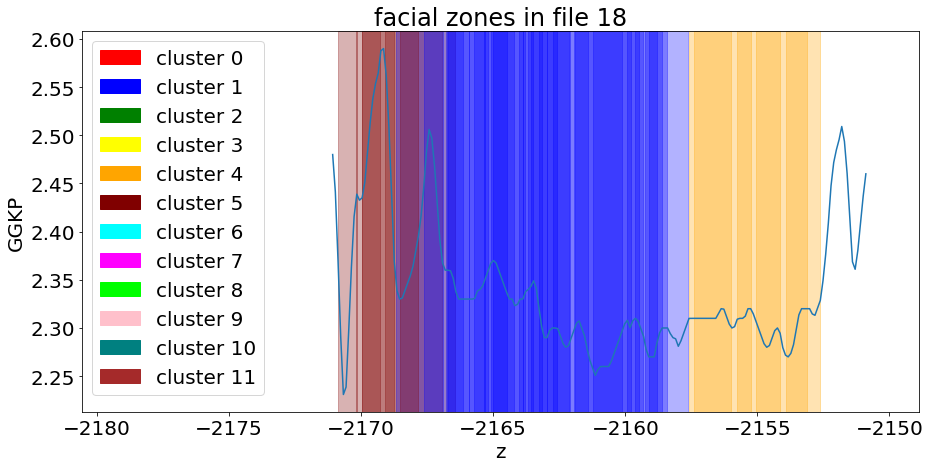

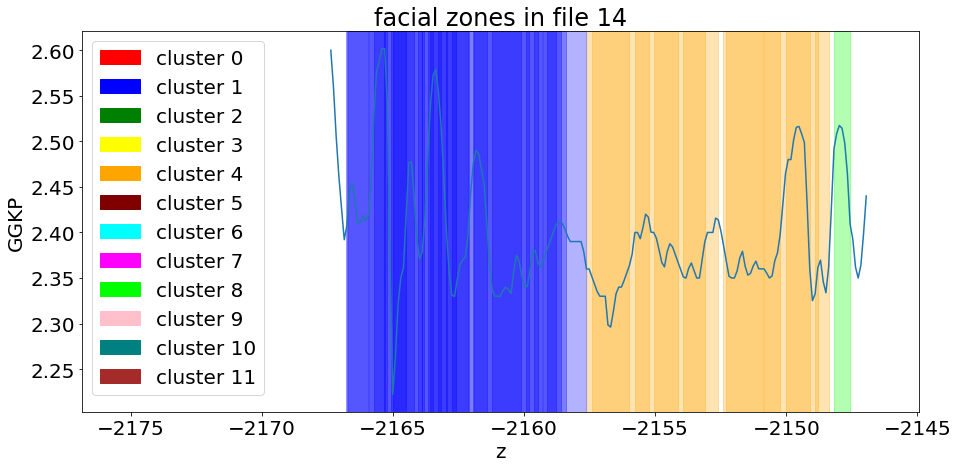

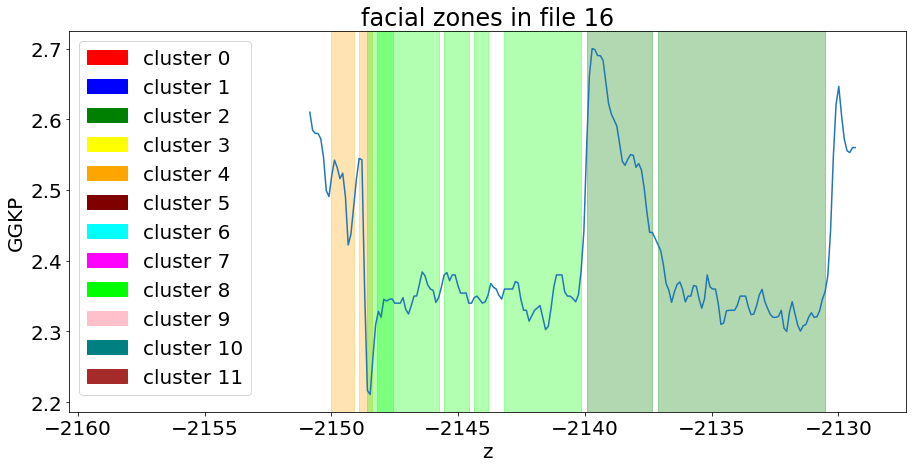

In [33]:
import matplotlib.patches as mpatches
for files in range(len(well_idx)):
    plt.figure(figsize=(15, 7))
    plt.plot(z[files], data[files])
    for k in range(len(z_new_new)):
        if (min(z[files]) < background_start[k]) and (max(z[files]) > background_end[k]):
            color = colors[list(colors.keys())[labels[k]]]
            plt.axvspan(background_start[k], background_end[k], color=color, alpha=0.3)
    plt.title("facial zones in file "+list(well_idx)[files])
    plt.xlim([min(z[files]) - 9.5, max(z[files]) + 2])
    plt.xlabel("z")
    plt.ylabel("GGKP")
    patches = []
    for col in range(len(list(colors.keys()))):
         patches.append(mpatches.Patch(color= colors[list(colors.keys())[col]], label='cluster '+str(col)))
    plt.legend(loc="upper left", handles=patches)
    plt.savefig("facial zones in file "+list(well_idx)[files]+".png")
    plt.show()